In [1]:
# SYSTEM
from os import sys, cpu_count
from time import time
from multiprocessing import Process
from multiprocessing.shared_memory import SharedMemory

# DATA TOOLS
import pickle
import numpy as np
import pandas as pd
#import scipy as sp
import scipy.stats as stats
from sklearn.preprocessing import normalize#, PolynomialFeatures
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans#, MeanShift
from sklearn.linear_model import  LinearRegression#, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor#, GradientBoostingRegressor
#from sklearn.svm import SVR

# VISUALIZATION
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# PACKAGE CONFIG
mpl.rcParams.update({'font.size':16})

In [2]:
df = pd.read_csv('./input/train.csv')

In [3]:
# An array of the cumulative inflation rates for the years 2006-2010 until 2021
# IE between 2006 and 2021 there is a cumlative rate of inflation equal to 29.8%
inflation2021 = np.array([[2006,0.29752976],
                          [2007,0.26159678],
                          [2008,0.21494824],
                          [2009,0.21928618],
                          [2010,0.19960927]])

# Function which, given YrSold, converts associated value of SalePrice
# by accounting for inflation. A Box-Cox transform is then performed on
# the adjusted value to make the distribution more normal looking.
def adj4inf(YEAR, DOLLARS):
    for i in range(len(inflation2021)):
        if YEAR == inflation2021[i,0]:
            adjvalue = DOLLARS*(1+inflation2021[i,1])
            break
    return np.log(adjvalue) # Note the logarithm feat. Box-Cox(1964)
df.shape

(1460, 81)

In [4]:
if 'adjprice' in df:
    None
else:
    adjprices = []
    for i in range(len(df)):
        adjprices.append(adj4inf(df['YrSold'][i],df['SalePrice'][i]))
    df.insert(loc=81,column='adjprice',value=adjprices)
    del adjprices
df.iloc[0:5,70:]

,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,adjprice
0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.442396
1,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.341389
2,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.511868
3,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,12.109860
4,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.623918


p = 2.81836e-06
The null hypothesis can be rejected


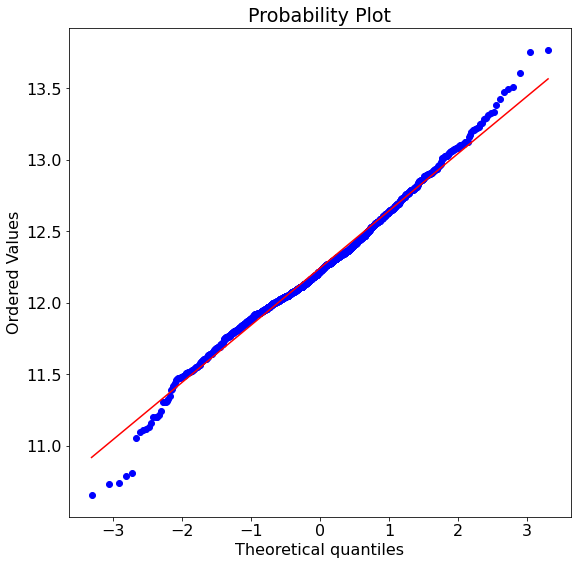

In [5]:
#target, lamda = stats.boxcox(np.array(df['adjprice']))
#target = np.array(df[df[VAR] == '2Story']['SalePrice'])
target = np.array(df['adjprice'])

k2, p = stats.normaltest(target)
alpha = 50e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
fig, ax = plt.subplots(figsize= (9,9))
stats.probplot(target,plot=ax)
plt.show()

# Missing Values 

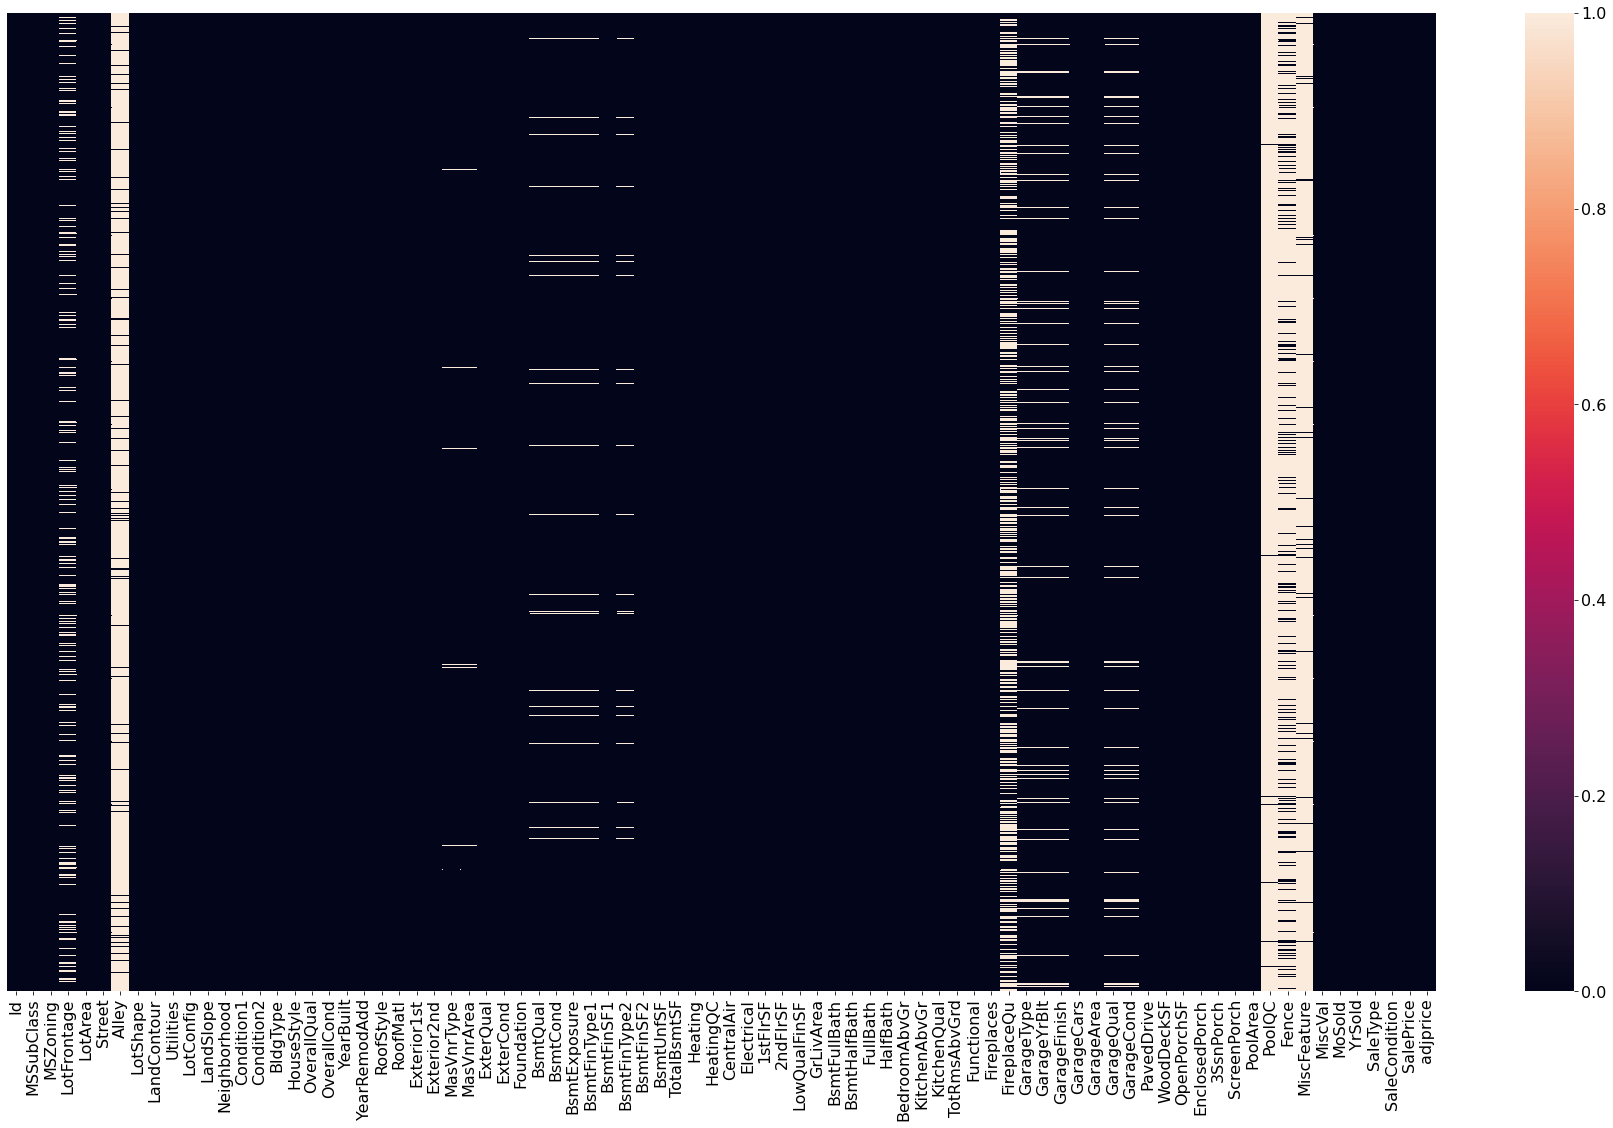

In [6]:
plt.figure(figsize=(32,18))
sns.heatmap(df.isnull())
plt.tick_params(left=False,
                labelleft=False)
plt.show()

In [7]:
df.columns[df.isnull().any() == True]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

## LotFrontage

A NaN for LotFrontage could indicate may indicate there is no street access to the parcel. Since zero of the parcels which have an NaN for LotFrontage have a NaN for Street type, I will replace the NaN in LotFrontage with the product of the mean frontage ratio for all data and the LotArea where the LotFrontage is missing.

In [8]:
mean_frontage_ratio = np.mean(df['LotFrontage']/df['LotArea'])
df['LotFrontage'].replace(np.nan,mean_frontage_ratio*df['LotArea'],inplace=True)

In [9]:
df.columns[df.isnull().any() == True]

Index(['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

## Alley

In [10]:
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [11]:
df['Alley'].replace(np.nan,'None',inplace=True)

##  MasVnrType, MasVnrArea

In [12]:
df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [13]:
df['MasVnrArea'].replace(np.nan,0,inplace=True)
df['MasVnrType'].replace(np.nan,'None',inplace=True)
df.columns[df.isnull().any() == True]

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

## BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2

In [14]:
df['BsmtQual'].replace(np.nan,'None',inplace=True)
df['BsmtCond'].replace(np.nan,'None',inplace=True)
df['BsmtExposure'].replace(np.nan,'None',inplace=True)
df['BsmtFinType1'].replace(np.nan,'None',inplace=True)
df['BsmtFinType2'].replace(np.nan,'None',inplace=True)
df.columns[df.isnull().any() == True]

Index(['Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

## Electrical

In [15]:
df[df['Electrical'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,adjprice
1379,1380,80,RL,73.0,9735,Pave,None,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2008,WD,Normal,167500,12.22344


In [16]:
df['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [17]:
df['Electrical'].replace(np.nan,'SBrkr',inplace=True)
df.columns[df.isnull().any() == True]

Index(['FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

## FireplaceQu

In [18]:
df['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [19]:
len(df[df['FireplaceQu'].isnull() & df['Fireplaces'] != 0])

0

In [20]:
df['FireplaceQu'].replace(np.nan,'None',inplace=True)
df.columns[df.isnull().any() == True]

Index(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

## GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond

In [21]:
df['GarageType'].replace(np.nan,'None',inplace=True)
df['GarageYrBlt'].replace(np.nan,df['GarageYrBlt'].mean(),inplace=True)
df['GarageFinish'].replace(np.nan,'None',inplace=True)
df['GarageQual'].replace(np.nan,'None',inplace=True)
df['GarageCond'].replace(np.nan,'None',inplace=True)

df.columns[df.isnull().any() == True]

Index(['PoolQC', 'Fence', 'MiscFeature'], dtype='object')

## PoolQC

In [22]:
len(df[df['PoolQC'].isnull() & df['PoolArea'] != 0])

0

In [23]:
df['PoolQC'].replace(np.nan,'None',inplace=True)

## Fence

In [24]:
df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [25]:
df['Fence'].replace(np.nan,'None',inplace=True)

## MiscFeature

In [26]:
df['MiscFeature'].value_counts()

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [27]:
df['MiscFeature'].replace(np.nan,'None',inplace=True)

In [28]:
#!rm datatypes.npy

In [29]:
# datatype array contains what type of data is contained in each column of df
#
# KEY
# ==========
# 0 - nominal
# 1 - ordinal
# 2 - interval
# 3 - ratio

try:
    with open('./datatypes.npy','rb') as f:
        datatype = np.load(f)
except:
    datatype = np.zeros(len(df.columns))
    for i in range(len(df.columns)):
        datatype[i] = input(f'{df.columns[i]}')
        np.save('./datatypes.npy',datatype)
datatype[0:5]

array([3., 0., 0., 3., 3.])

In [30]:
categoric = []
numeric = []
for i in range(len(datatype)):
    if datatype[i] <= 1:
        categoric.append(df.columns[i])
    else:
        numeric.append(df.columns[i])

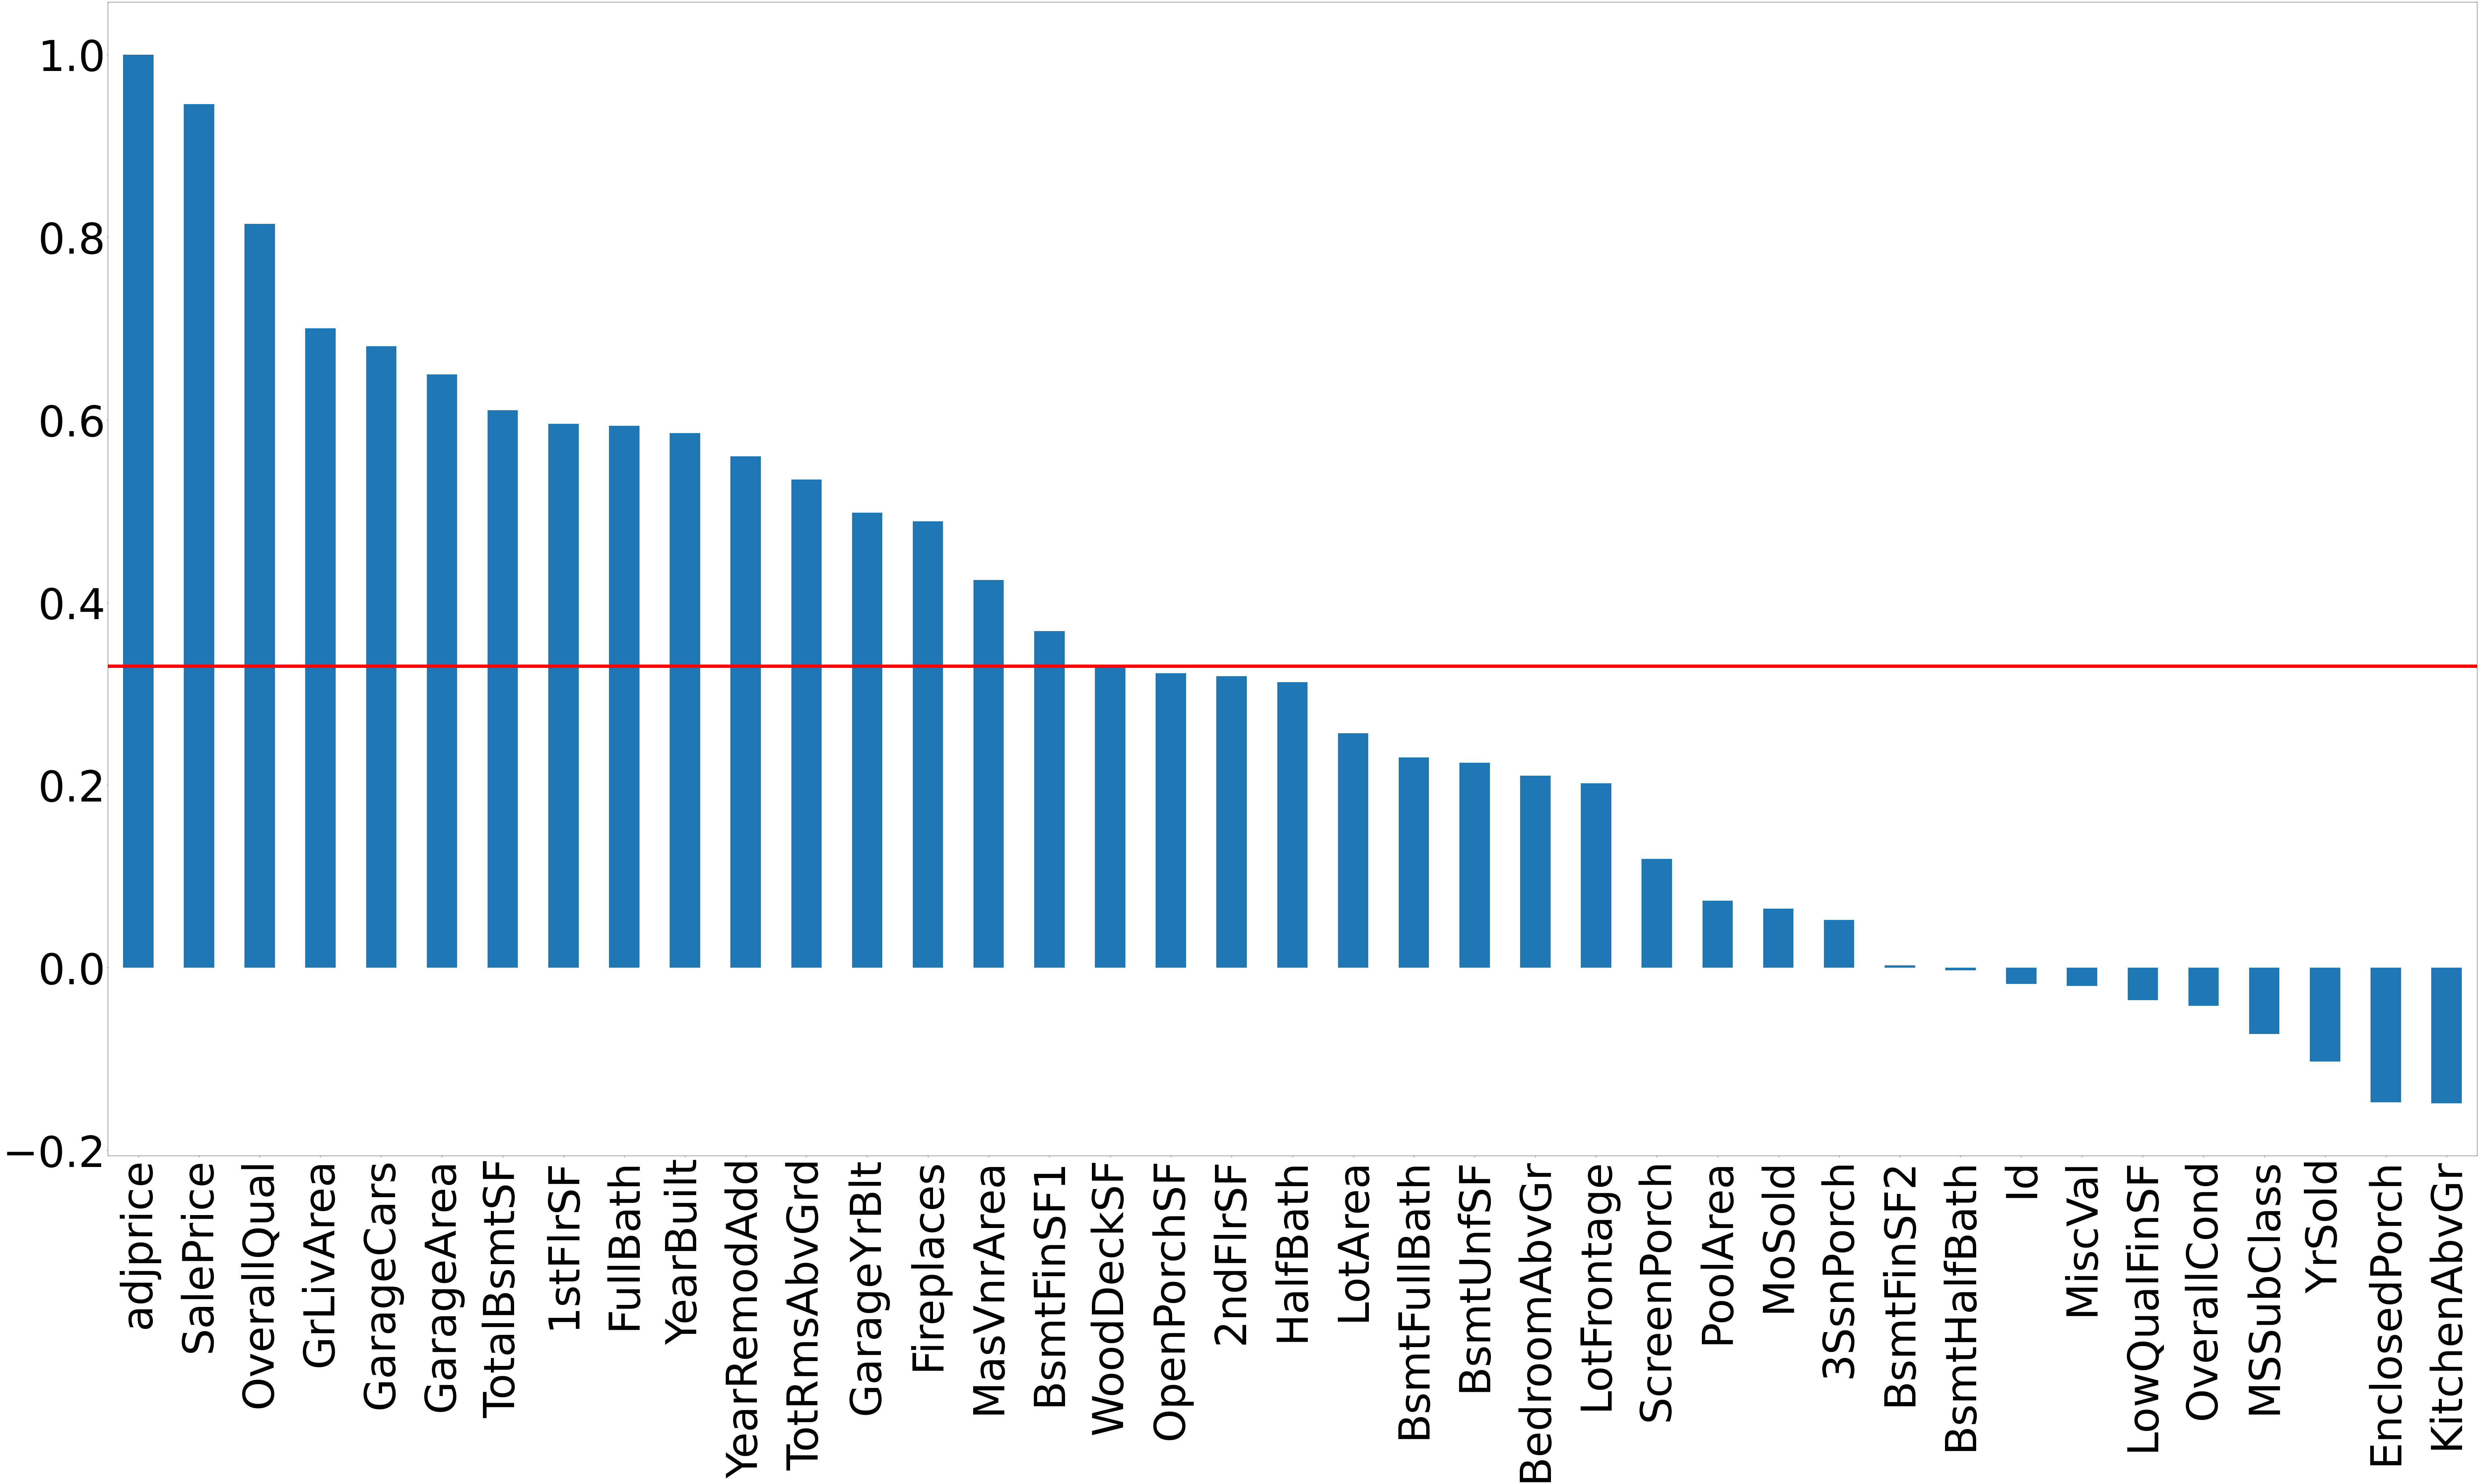

In [31]:
plt.figure(figsize=(128,64))
df.corr()['adjprice'].sort_values(ascending=False).plot(kind='bar')
plt.axhline(0.33,color = 'red',linewidth=10)
plt.tick_params(labelsize=128)
plt.show()

In [32]:
df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

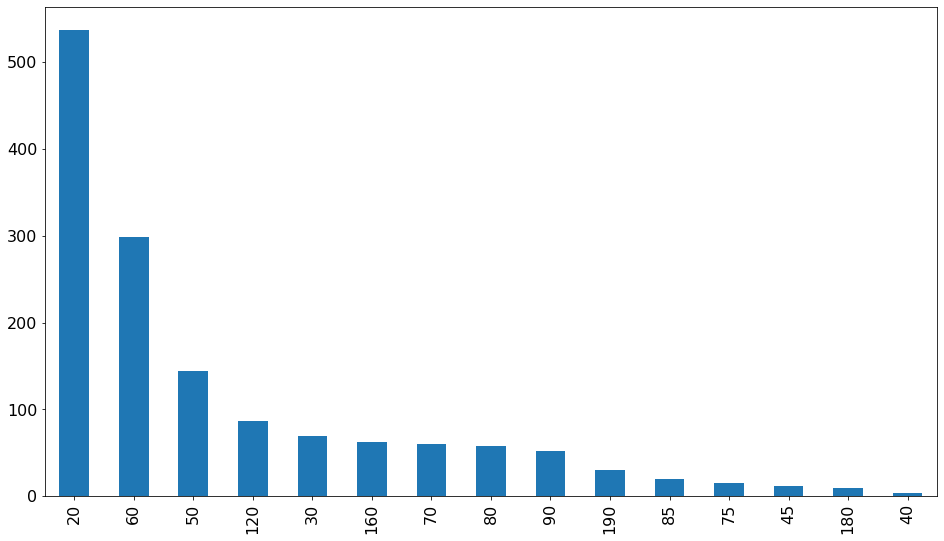

In [33]:
plt.figure(figsize=(16,9))
df['MSSubClass'].value_counts().plot(kind='bar')
plt.show()

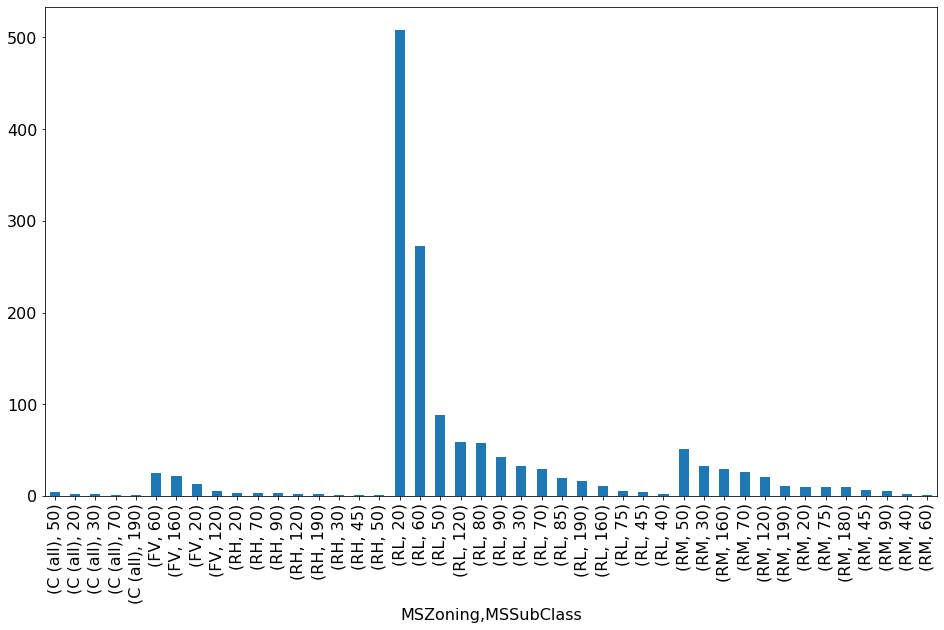

In [34]:
plt.figure(figsize=(16,9))
df.groupby('MSZoning')['MSSubClass'].value_counts().plot(kind='bar')
plt.show()

In [35]:
def get_vecs(FEATURE, DATAFRAME, TARGET):
    vector = []
    variables = np.array(DATAFRAME.loc[:,FEATURE].value_counts().index,dtype=object)
    for i in range(len(variables)):
        vector.append(DATAFRAME[DATAFRAME.loc[:,FEATURE] == variables[i]][TARGET])
    return np.asarray(vector, dtype=object), variables

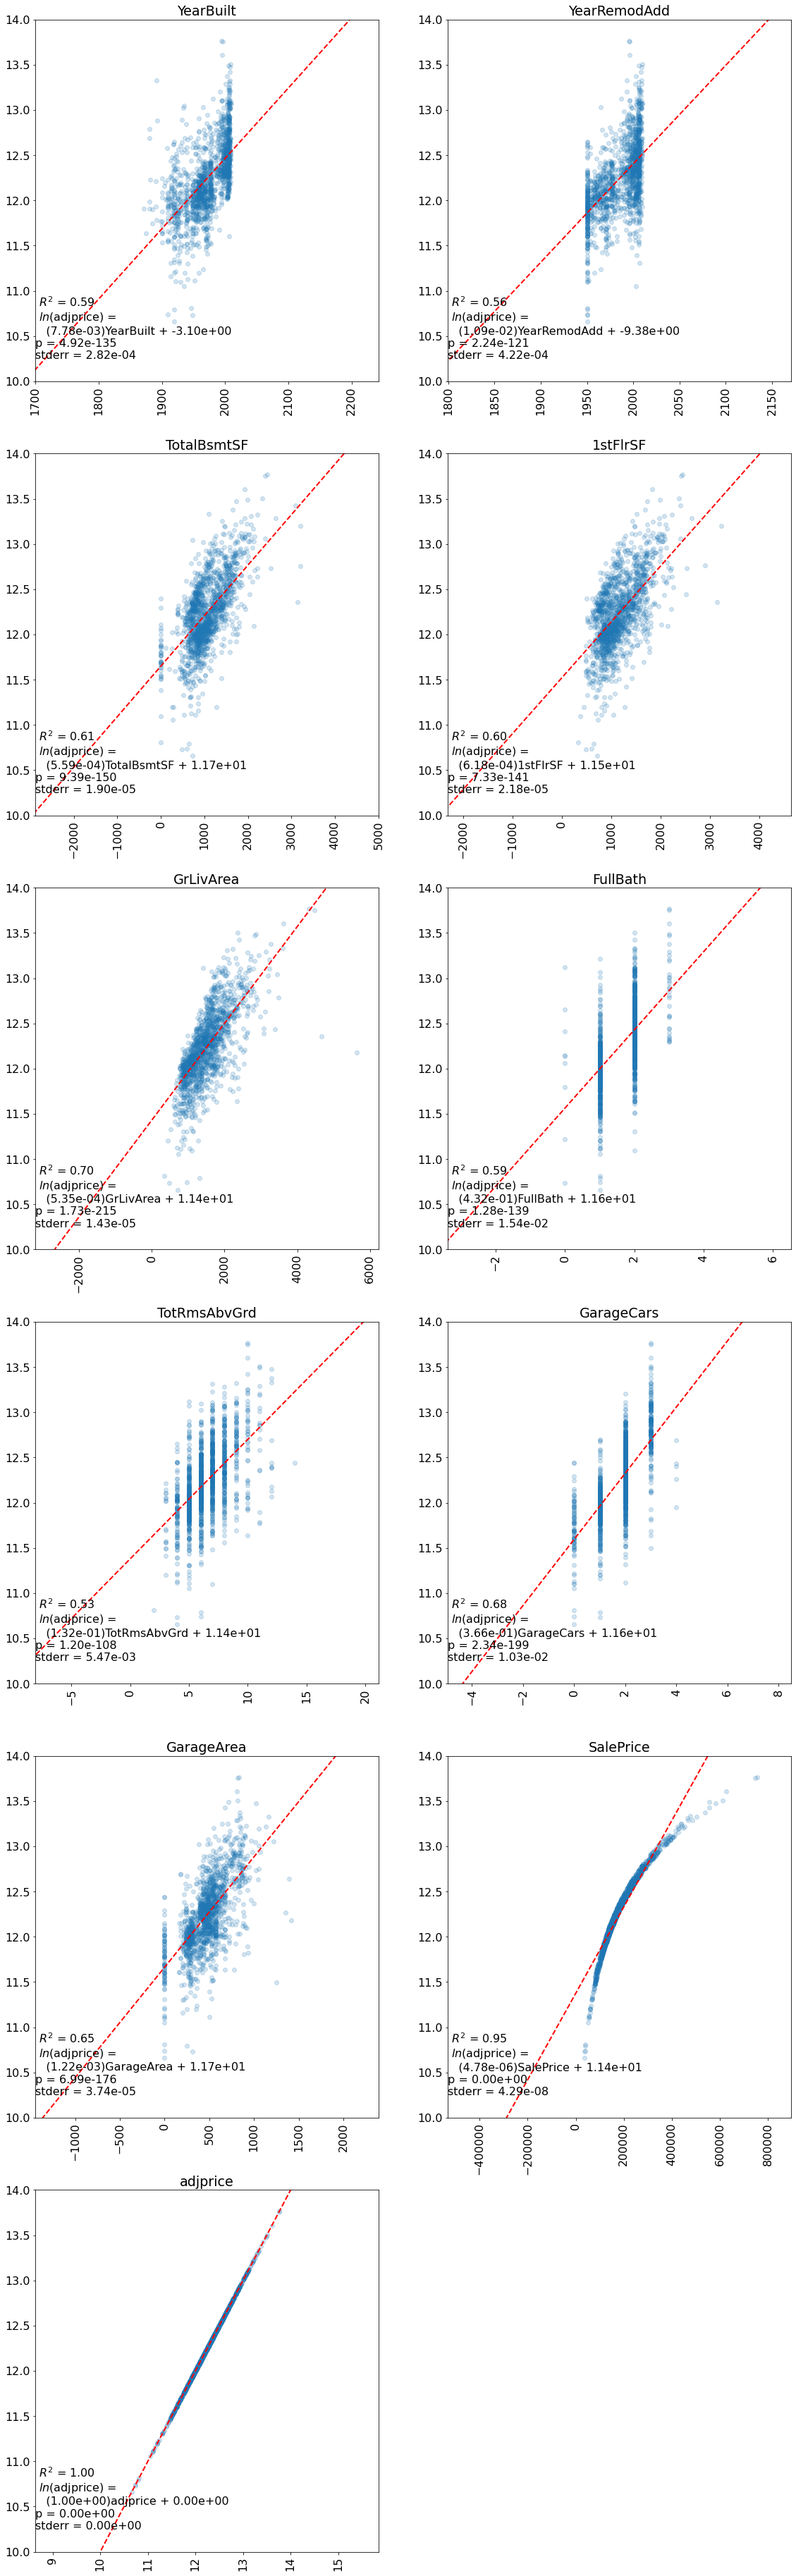

In [36]:
def bestfit(NUMERIC, TARGET):
    slope, intercept, r, p, std_err = stats.linregress(NUMERIC, TARGET)
    return slope, intercept

fig, axs = plt.subplots(figsize=(16,256))
fig.tight_layout()
j = 0
for i in range(1,len(numeric)):
    
    slope, intercept, r, p, std_err = stats.linregress(df[numeric[i]],df['adjprice'])
    if r >= 0.5:
        j = j+1
        devs = 9
        xmin = np.mean(df[numeric[i]]) - devs*np.std(df[numeric[i]])
        xmax = np.mean(df[numeric[i]]) + devs*np.std(df[numeric[i]])
        domain = np.linspace(-1e9,1e9,10)
        y_pred = slope*domain + intercept
        plt.subplot(30,2,j)
        plt.xlim(xmin,xmax)
        plt.ylim(10,14)
        plt.scatter(df[numeric[i]],df['adjprice'],alpha=0.2)
        plt.plot(domain,y_pred,c = 'r', linestyle='--',linewidth=2)
        plt.xticks(rotation=90)
        plt.text(xmin,10.25,
        f' $R^2$ = {r:.2f}\
        \n $ln$(adjprice) =\
        \n   ({slope:.2e}){numeric[i]} + {intercept:.2e}\
        \np = {p:.2e}\nstderr = {std_err:.2e}')
        plt.title(numeric[i])
    else:
        continue

plt.show()

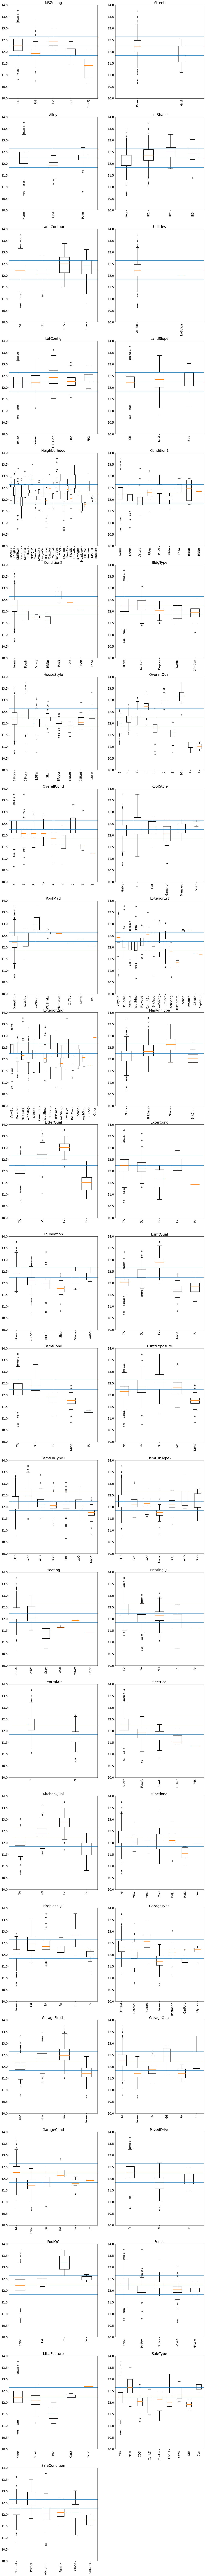

In [37]:
fig, ax = plt.subplots(figsize=(16,256))
fig.tight_layout()
for i in range(1,len(categoric)):
    vecs = get_vecs(categoric[i],df,'adjprice')
    plt.subplot(30,2,i)
    plt.ylim(10,14)
    plt.boxplot(vecs[0],labels=vecs[1])
    plt.xticks(rotation=90)
    plt.title(categoric[i])
    plt.axhline(df['adjprice'].mean(), c = 'C0')
    plt.axhline(df['adjprice'].mean() + np.std(df['adjprice']), c = 'C0')
    plt.axhline(df['adjprice'].mean() - np.std(df['adjprice']), c = 'C0')
plt.show()

In [38]:
def get_ranks(FEATURE, DATAFRAME, TARGET):
    ftr_mean = np.zeros(len(DATAFRAME[FEATURE].unique()))
    vecs = get_vecs(FEATURE, DATAFRAME, TARGET)
    for i in range(len(ftr_mean)):
        ftr_mean[i] = np.mean(vecs[0][i])
    ftr_rank = np.zeros(len(DATAFRAME),dtype=np.float64)
    target_mean = np.mean(DATAFRAME[TARGET])
    target_std = np.std(DATAFRAME[TARGET])
    for i in range(len(df)):
        for j in range(len(vecs[1])):
            if DATAFRAME[FEATURE][i] == vecs[1][j]:
                if  ftr_mean[j] <= (target_mean - target_std):
                    ftr_rank[i] = 1
                if (ftr_mean[j] > (target_mean - target_std)) & (ftr_mean[j] <= target_mean):
                    ftr_rank[i] = 2
                if (ftr_mean[j] <= (target_mean + target_std)) & (ftr_mean[j] > target_mean):
                    ftr_rank[i] = 3
                if (ftr_mean[j] > (target_mean + target_std)):
                    ftr_rank[i] = 4
    return ftr_rank

In [40]:
#for i in range(len(df_model.columns)):
#    print("'"+df_model.columns[i]+"',")

#  Basic Model

In [41]:
!rm 'allcat.pkl'

In [42]:
# Begin by including all features in our model
filename = 'allcat.pkl'

try:
    with open(filename,'rb') as f:
        df_model = pickle.load(f)
except:    
    print('Building new model')
    df_model = pd.DataFrame()
    for i in range(len(categoric)):
        try:
            tmp_str = categoric[i] + '_ranks'
            df_model.loc[:,tmp_str] = get_ranks(categoric[i],df,'adjprice')
        except:
            continue
    df_cats = df.loc[:,numeric]
    df_model = df_cats.merge(df_model, how='inner', left_index=True,right_index=True)
    df_model = df_model.drop('SalePrice',axis=1)
    df_model = df_model.drop('adjprice',axis=1)
    with open(filename,'wb') as f:
        pickle.dump(df_model,f)
df_model[0:5]

Building new model


,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageType_ranks,GarageFinish_ranks,GarageQual_ranks,GarageCond_ranks,PavedDrive_ranks,PoolQC_ranks,Fence_ranks,MiscFeature_ranks,SaleType_ranks,SaleCondition_ranks
0,1,65.0,8450,2003,2003,196.0,706,0,150,856,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0
1,2,80.0,9600,1976,1976,0.0,978,0,284,1262,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0
2,3,68.0,11250,2001,2002,162.0,486,0,434,920,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0
3,4,60.0,9550,1915,1970,0.0,216,0,540,756,...,2.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0
4,5,84.0,14260,2000,2000,350.0,655,0,490,1145,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0


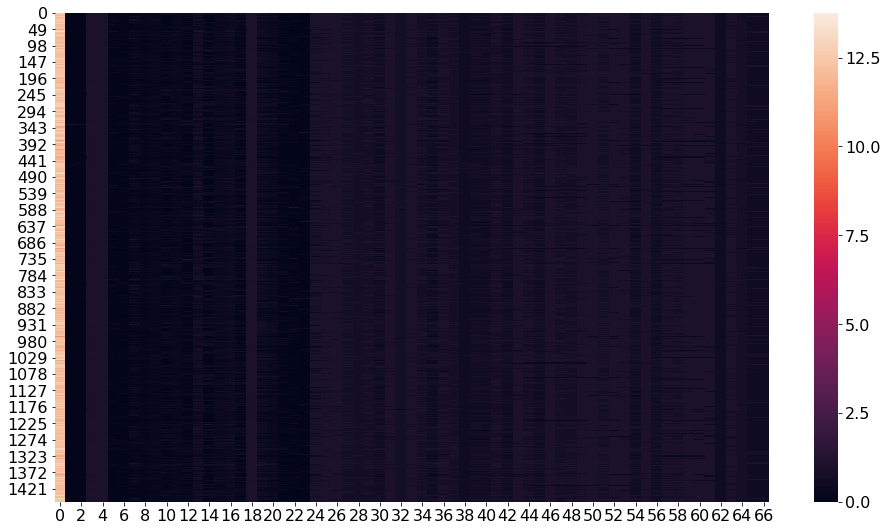

In [163]:
#X = np.array(df_model,dtype = np.float64)
#y = np.array(df.adjprice, dtype=np.float64)#df_model.iloc[:,0]


yX = np.array(df_model,dtype=np.float64)
yX = normalize(yX, norm='max', axis=0)
yX[:,0] = df['adjprice']

labels = list(df_model.columns)
labels[0] = 'adjprice'

#print(labels)
plt.figure(figsize=(16,9))
sns.heatmap(yX[:,:])
plt.show()

In [166]:
#fig, ax = plt.subplots(figsize=(16,384))
#fig.tight_layout()
j = 0
newcats = []
for i in range(1,len(labels)):
        r, p = stats.pearsonr(yX[:,i],yX[:,0])
        if (r >= 0.075) & (p < 0.05):
            j = j+1
            """
            plt.subplot(50,2,j)
            ax = sns.regplot(yX[:,i], # X
                             yX[:,0], # y
                             scatter_kws={'alpha':0.2},
                             line_kws={'color':'C1'}
                            )
            ax.set(xlabel = labels[i]+' (dimensionless)',
                   ylabel = labels[0]+' ln($USD)',
                   ylim = (10.5,14)
                  )
            """
            newcats.append(labels[i])
        else:
            continue
#plt.show()

In [167]:
df_model = pd.merge(df.adjprice,df_model.loc[:,newcats],left_index=True,right_index=True)
print(df_model.columns)
print(df_model.shape)
df_model[0:5]

Index(['adjprice', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch',
       'MSSubClass_ranks', 'MSZoning_ranks', 'Alley_ranks', 'LotShape_ranks',
       'LandContour_ranks', 'LotConfig_ranks', 'Neighborhood_ranks',
       'Condition1_ranks', 'Condition2_ranks', 'BldgType_ranks',
       'HouseStyle_ranks', 'OverallQual_ranks', 'OverallCond_ranks',
       'RoofStyle_ranks', 'RoofMatl_ranks', 'Exterior1st_ranks',
       'Exterior2nd_ranks', 'MasVnrType_ranks', 'ExterQual_ranks',
       'ExterCond_ranks', 'Foundation_ranks', 'BsmtQual_ranks',
       'BsmtCond_ranks', 'BsmtExposure_ranks', 'BsmtFinType1_ranks',
       'BsmtFinType2_ranks', 'Heating_ranks', 'HeatingQC_ranks',
       'CentralAir_ra

,adjprice,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageType_ranks,GarageFinish_ranks,GarageQual_ranks,GarageCond_ranks,PavedDrive_ranks,PoolQC_ranks,Fence_ranks,MiscFeature_ranks,SaleType_ranks,SaleCondition_ranks
0,12.442396,65.0,8450,2003,2003,196.0,706,150,856,856,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0
1,12.341389,80.0,9600,1976,1976,0.0,978,284,1262,1262,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0
2,12.511868,68.0,11250,2001,2002,162.0,486,434,920,920,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0
3,12.109860,60.0,9550,1915,1970,0.0,216,540,756,961,...,2.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0
4,12.623918,84.0,14260,2000,2000,350.0,655,490,1145,1145,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0


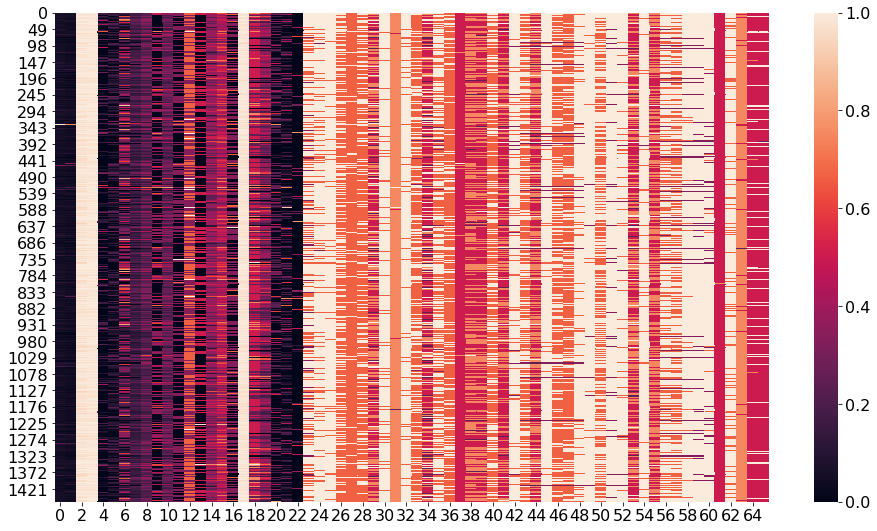

In [162]:
template = np.zeros((df_model.shape),dtype=np.float64)
yX_shm = SharedMemory(create=True, size=template.nbytes)
yX = np.ndarray(template.shape, dtype=template.dtype, buffer=yX_shm.buf)

yX[:] = np.array(df_model,dtype=np.float64)[:]
yX = normalize(yX, norm='max', axis=0)
yX[:,0] = df['adjprice']
plt.figure(figsize=(16,9))
sns.heatmap(yX[:,1:])
plt.show()

In [47]:
# MULTIPROCESSING DEFINITIONS

"""
Given an input array, this function returns an array containing
the start positions of jobs as well as job length based on the 
number of cpus available.
"""
def divide_work(ARRAY, WORK_INDEX):
    n_cpus = cpu_count()
    job_len = np.floor(ARRAY.shape[WORK_INDEX]/n_cpus)
    work_schedule = np.zeros((n_cpus,2), dtype=np.longlong) # [(start_position),(job_length)]
    for i in range(0,n_cpus):
        distance = i*job_len
        work_schedule[i,0] =  distance 
        if i != (n_cpus - 1): # The length of the last job is dynamic 
            work_schedule[i,1] = job_len
        else:
            work_schedule[i,1] = ARRAY.shape[WORK_INDEX] - distance
    return work_schedule


def score_model(INPUT, OUTPUT, MODEL_TYPE, OFFSET, DURATION):
    X = INPUT[:,1:]
    y = INPUT[:,0]
    for i in range(0, DURATION):
        rng = np.random.default_rng()
        state = rng.integers(1e9)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = state)
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        OUTPUT[0][i + OFFSET] = reg.score(X_test,y_test)
        y_pred = np.exp(reg.predict(X_test),dtype = np.float64)
        y_actual = np.apply_along_axis(np.exp,0,y_test)
        RMSE = np.sqrt(np.mean(y_pred - y_actual)**2)
        OUTPUT[1][i + OFFSET] = RMSE


"""
Given an input & output array, a task, and a work schedule,
this function starts a process which starts processes to 
perform the indicated task on the input array according to
the work schedule and write the output to the output array.

For more info on the "work schedule," see above
"""
def assign_work(INPUT, TASK, MODEL_TYPE, WORK_SCHEDULE, OUTPUT):
    processes = []
    for i in range(len(WORK_SCHEDULE)):
        #print(f'start {i}')
        p = Process(target=TASK, args=(INPUT,OUTPUT, MODEL_TYPE, WORK_SCHEDULE[i,0], WORK_SCHEDULE[i,1]))
        processes.append(p)
        p.start()
    for i in range(len(WORK_SCHEDULE)):
        #print(f'join {i}')
        processes[i].join()

def draw_plots(MODEL_TYPE, WORKOUTPUT, BINS):
    plt.subplots(2,1,figsize=(16,16))
    xlab = ['$R^2$','RMSE\n($USD, adjusted for inflation 2021)']
    xlims = np.array(((-1.0,1.0),
                    (0.0,180000.0)))
    for i in range(0,2):
        plt.subplot(2, 1, i + 1)
        plt.hist(WORKOUTPUT[i],bins=BINS)
        plt.title(f'{str(MODEL_TYPE)} (N={testlen:,})')
        plt.xlabel(xlab[i])
        plt.xlim(xlims[i,0],xlims[i,1])
        plt.ylabel('Frequency')
    plt.show()

    print('========')
    print('Scores ')
    tmp = stats.describe(WORKOUTPUT[0])
    for i in range(len(tmp)):
        buf =  (8 - len(tmp._fields[i]))*' '
        print(f'  {tmp._fields[i]}:{buf}\t{tmp[i]}')

    print('========')
    print(' Error  ')
    tmp = stats.describe(WORKOUTPUT[1])
    for i in range(len(tmp)):
        buf =  (8 - len(tmp._fields[i]))*' '
        print(f'  {tmp._fields[i]}:{buf}\t{tmp[i]}')

In [48]:
#!rm 'firstlinear.pkl'

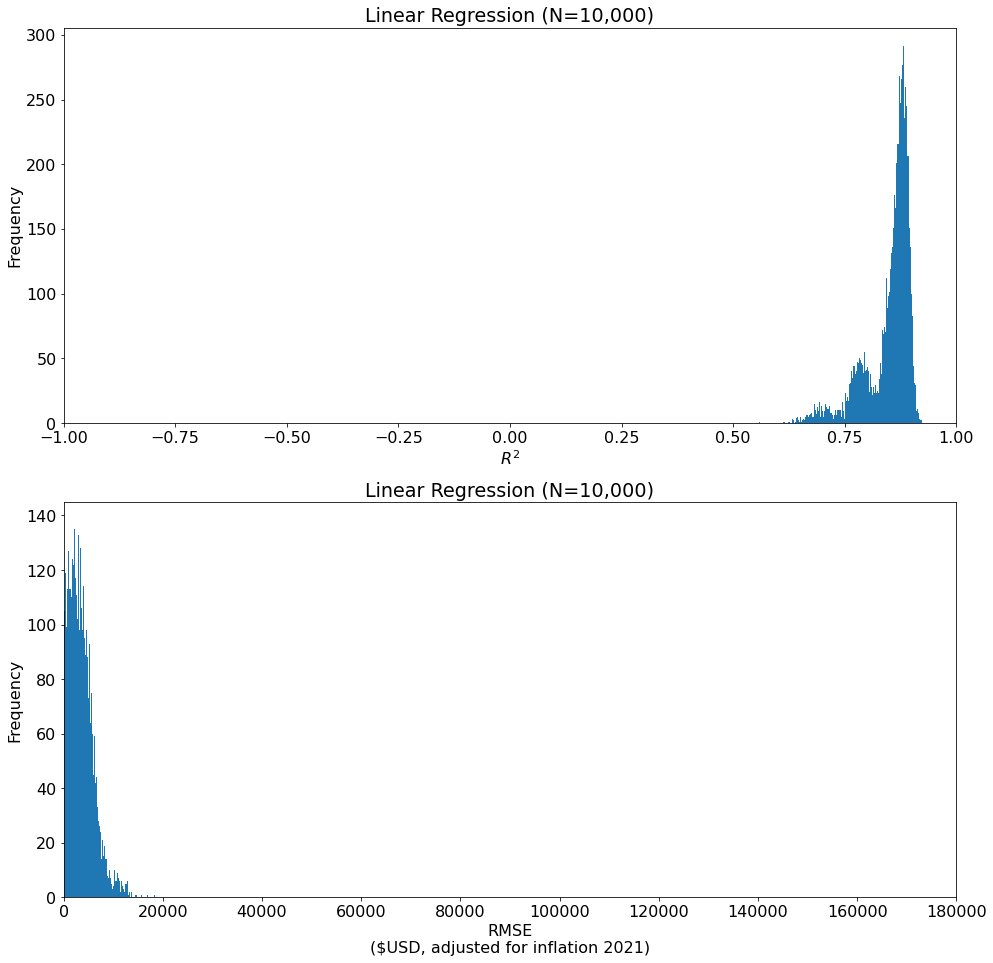

Scores 
  nobs:    	10000
  minmax:  	(0.5304475142447821, 0.9228978094512587)
  mean:    	0.8490997984327038
  variance:	0.002610314687180087
  skewness:	-1.6723570435081407
  kurtosis:	2.7343307975983864
 Error  
  nobs:    	10000
  minmax:  	(1.0710829805112017, 18338.533237340944)
  mean:    	3510.1572571278816
  variance:	6250279.174001775
  skewness:	1.1327943044336537
  kurtosis:	1.86813592614092


In [49]:
filename = 'firstlinear.pkl'
testlen = 10000
try:
    with open(filename,'rb') as f:
        output = pickle.load(f)
except:
    start_time = time()
    template = np.zeros(testlen,dtype=np.float64)
    scores_shm = SharedMemory(create=True, size=template.nbytes)
    scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)
    error_shm = SharedMemory(create=True, size=template.nbytes)
    error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)
    model = LinearRegression()
    output = [scores,error]
    job_list = divide_work(template, 0)
    start_time = time()
    if __name__ == '__main__':  
        assign_work(yX, score_model, model, job_list, output)
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    with open(filename,'wb') as f:
        pickle.dump(output, f)
    
draw_plots('Linear Regression',output,250)

#### The RMSE distribution is multimodal. This may indicate the presence of groups of samples with responses to the explanatory variables that are characteristic of that group. (Clusters) The four bumps in the RMSE distribution suggest the presense of four clusters.

## HYPOTHESIS: The data clusters best into four clusters.

#### Let's test different numbers of clusters and see what the best number of clusters is.

In [50]:
def score_clusters(INPUT, OUTPUT, MODEL_TYPE, OFFSET, DURATION):
    X = INPUT[:,1:]
    for i in range(0, DURATION):
        rng = np.random.default_rng()
        mask = rng.choice([True, False], size=len(X), p=[0.8, 0.2])
        X_masked = X[mask]
        cls = MODEL_TYPE
        cls.fit(X_masked)
        j = len(cls.cluster_centers_)
        OUTPUT[i + OFFSET][j] = cls.inertia_

In [51]:
#!rm 'inertiavclusters.pkl'

In [52]:
filename = 'inertiavclusters.pkl'
clusters = 10
testlen = 1000
try:
    with open(filename,'rb') as f:
        output = pickle.load(f)

except:
    start_time = time()

    template = np.zeros((testlen,clusters),dtype=np.float64)
    inertia_shm = SharedMemory(create=True, size=template.nbytes)
    inertia = np.ndarray(template.shape, dtype=template.dtype, buffer=inertia_shm.buf)
    output = inertia
    job_list = divide_work(template,0)
    start_time = time()
    if __name__ == '__main__':
        for i in range(1,clusters):
            model = KMeans(n_clusters = i)
            assign_work(yX, score_clusters, model, job_list, output)
            sys.stdout.write(f'{i}\t {time() - start_time:.2f}s\n')
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    with open(filename,'wb') as f:
        pickle.dump(output,f)

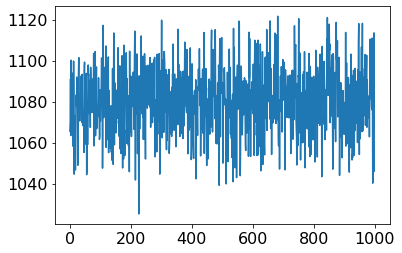

In [53]:
plt.plot(output[:,4])
plt.show()

## ELBOW METHOD!

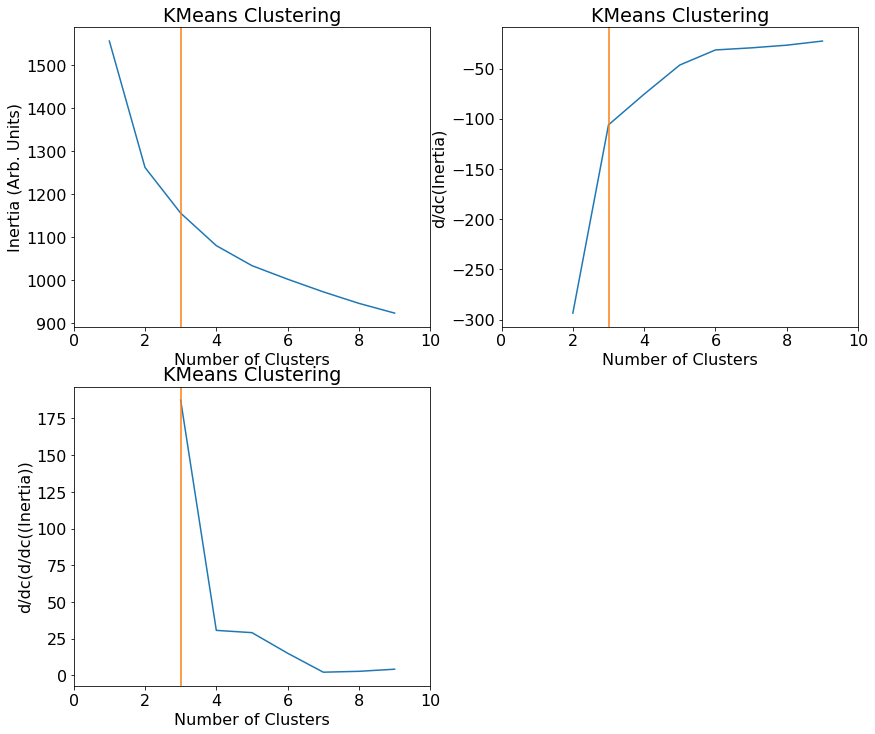

In [54]:
inertia_derivatives = np.zeros((clusters,3),dtype=np.float64)

ylabels = ['Inertia (Arb. Units)','d/dc(Inertia)', 'd/dc(d/dc((Inertia))']

for i in range(1,clusters):
    inertia_derivatives[i,0] = np.mean(output[:,i])
    inertia_derivatives[i,1] = inertia_derivatives[i,0] - inertia_derivatives[i-1,0]
    inertia_derivatives[i,2] = inertia_derivatives[i,1] - inertia_derivatives[i-1,1]
    
fig, ax = plt.subplots(figsize=(12,15))
fig.tight_layout()
for i in range(0,3):
    plt.subplot(3,2,i+1)
    plt.title('KMeans Clustering')
    plt.plot(np.arange(i+1,clusters),inertia_derivatives[(i+1):,i])
    plt.axvline(3,c='C1')
    plt.ylabel(str(ylabels[i]))
    plt.xlabel('Number of Clusters')
    plt.xlim(0,clusters)
plt.show()

### The second derivative of the inertia vs. number of clusters curve levels off around zero after four clusters. The hypothesis of four clusters we made by looking at the RMSE distribution cannot be rejected.

In [55]:
#!rm 'centers_fourclusters.pkl'

In [56]:
filename = 'centers_threeclusters.pkl'
clusters = 3

try:
    with open(filename,'rb') as f:
        centers = pickle.load(f)
except:
    testlen = 2500
    model = LinearRegression()
    kmeans = KMeans(n_clusters=clusters)
    centers = np.zeros((testlen,clusters))
    start_time = time()
    for i in range(0,testlen):
        rng = np.random.default_rng()
        mask = rng.choice([True, False], size=len(yX), p=[0.8, 0.2])
        X = yX[:,1:]
        X = X[mask]
        y = yX[:,0]
        y = y[mask]
        model.fit(X,y)
        kmeans.fit(X)
        y_pred = model.predict(kmeans.cluster_centers_)
        for j in range(0,clusters):
            centers[i,j] = np.sort(np.exp(y_pred))[j]
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    with open(filename,'wb') as f:
        pickle.dump(centers,f)

cluster 0: $122,373.0
cluster 1: $171,049.0
cluster 2: $291,453.0


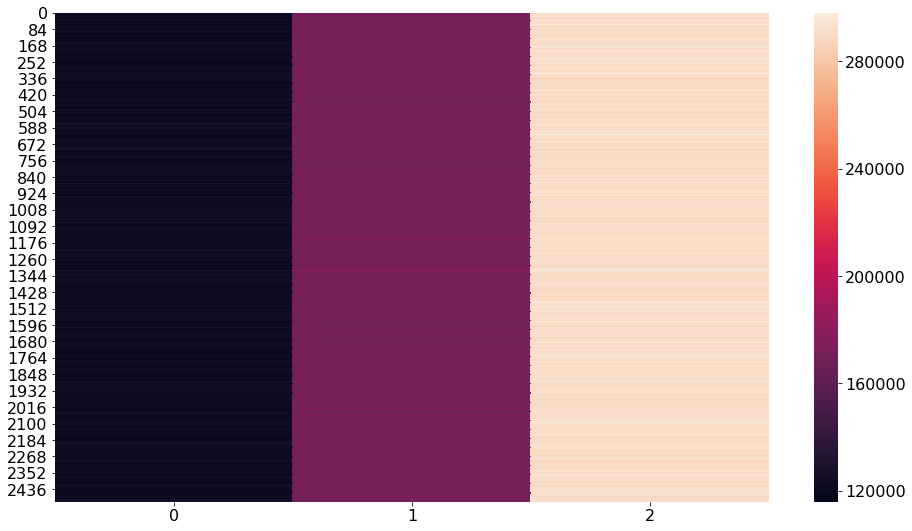

In [57]:
for i in range(0,3):
    print(f'cluster {i}: ${np.round(np.mean(centers[:,i]),):,}')

plt.figure(figsize=(16,9))
sns.heatmap(centers)
plt.show()

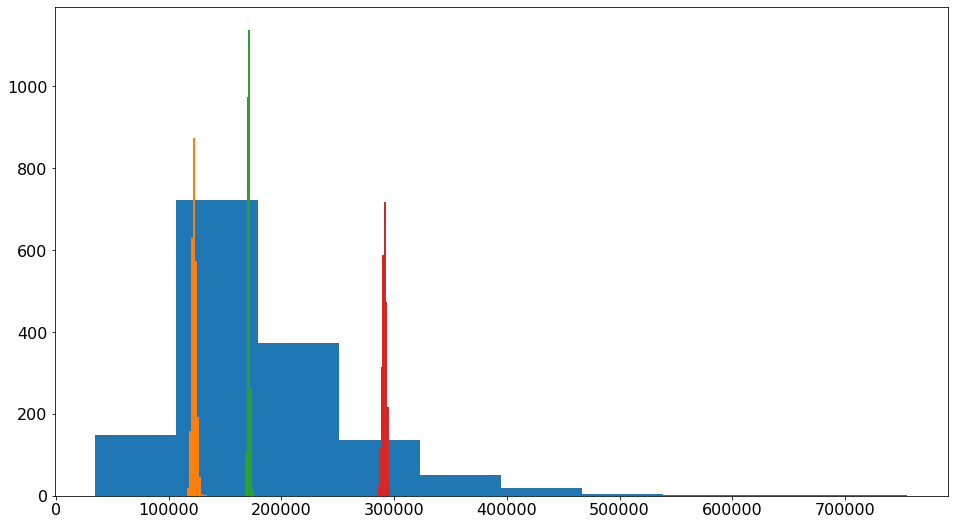

In [58]:
plt.figure(figsize=(16,9))
plt.hist(df.SalePrice,stacked=True)
for i in range(0,clusters):
    plt.hist(centers[:,i])
plt.show()

In [73]:
def assign_clusters(INPUT_FIT, OUTPUT, MODEL_TYPE, OFFSET, DURATION):
    X_fit = INPUT_FIT[:,1:]
    X_pred = X_fit
    y_fit = INPUT_FIT[:,0]
    centers = np.zeros((3,X_fit.shape[1]),dtype=np.float64)
    response = np.zeros((len(centers),2),dtype=np.float64)
    response_sorted = np.zeros((len(centers),2),dtype=np.float64)
    labels = np.zeros((len(X_fit),2),dtype=np.float64) # format: (original label, ordered label)
    
    for i in range(0, DURATION):
        seed = np.random.seed()
        rng = np.random.default_rng(seed)
        mask = rng.choice([True, False], size=len(X_fit), p=[0.8, 0.2])
        X_masked = X_fit[mask]
        y_masked = y_fit[mask]
        cls = MODEL_TYPE
        cls.fit(X_masked)
        centers = cls.cluster_centers_
        reg = LinearRegression()
        reg.fit(X_masked,y_masked)
        # Get response from centers and calculate y at those centers
        for j in range(0,len(centers)):
            response[j,0] = cls.predict(centers[j].reshape(1,-1))[0]
            response[j,1] = reg.predict(centers[j].reshape(1,-1))[0]
        # Sort centers in order of response
        for j in range(0,len(centers)):
            response_sorted[j] = response[np.argsort(response[:,1])[j]]
        # Get labels
        labels[:,0] = cls.predict(X_fit)
        # Now labels are reassigned in increasing response order
        # For each sample...
        for j in range(0,len(labels)):
            # loop through the cluster labels...
            for k in range(0,len(response_sorted)):
                # if the sample label matches the the *sorted* center label,
                # fill in the ordered label with the index
                if labels[j,0] == response_sorted[k,0]:
                    labels[j,1] = k
                # Since the centers are sorted, the new labels will be as well
            OUTPUT[i + OFFSET][j] = labels[j,1]

In [74]:
!rm 'threecluster_labels.pkl'

In [77]:
filename = 'threecluster_labels.pkl'
clusters = 3

try:
    with open(filename,'rb') as f:
        output = pickle.load(f)
except:
    testlen = 10000
    template = np.zeros((testlen,len(yX)), 
                        dtype=np.float64)
    clusters_shm = SharedMemory(create=True,
                                size=template.nbytes)
    cluster_labels = np.ndarray((testlen,len(yX)),
                                dtype=template.dtype, 
                                buffer=clusters_shm.buf)
    model = KMeans(n_clusters = clusters)
    output = cluster_labels
    job_list = divide_work(template, 0)
    start_time = time()

    if __name__ == '__main__':  
        assign_work(yX, assign_clusters, model, job_list, output)
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    
    with open(filename,'wb') as f:
        pickle.dump(output, f)


print(output.shape)

(10000, 1460)


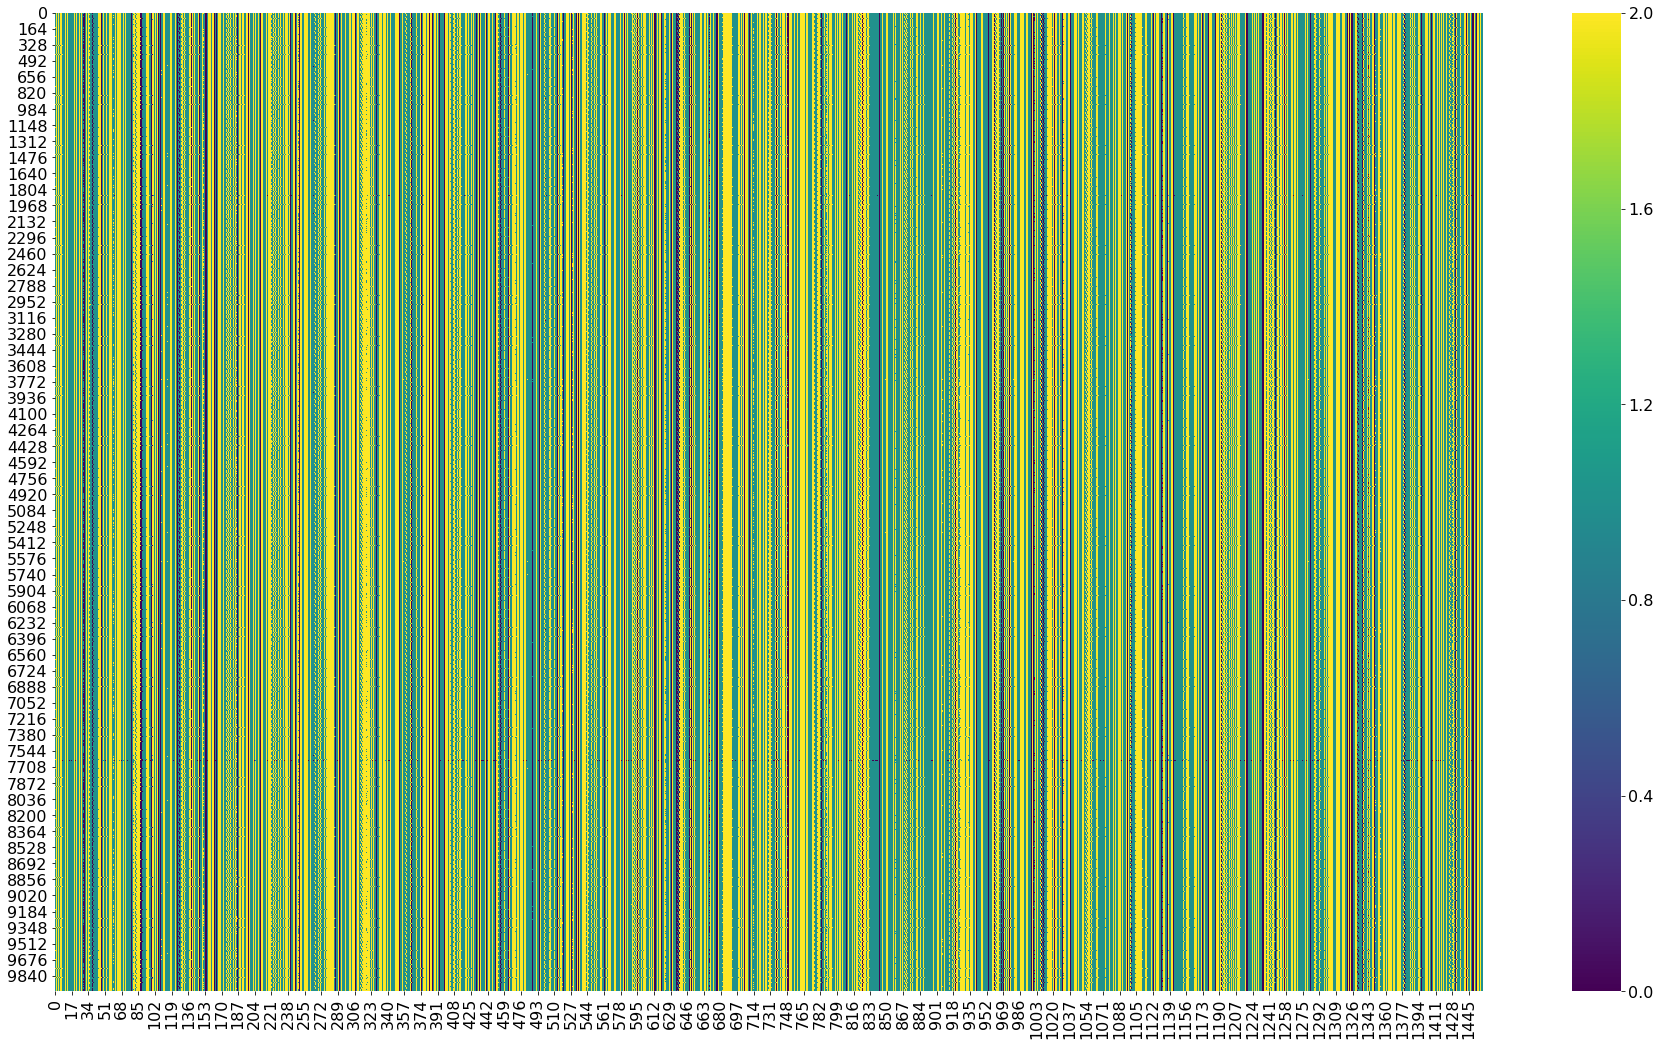

In [78]:
plt.figure(figsize=(32,18))
sns.heatmap(output,cmap='viridis')
plt.show()

In [79]:
!rm 'cluster_counts.pkl'

rm: cluster_counts.pkl: No such file or directory


In [80]:
filename = 'cluster_counts.pkl'
try:
    with open(filename,'rb') as f:
        cluster_counts = pickle.load(f)
except:
    start_time = time()
    cluster_counts = np.zeros((len(df),clusters),dtype = np.float64)
    for i in range(0,len(output)):
        for j in range(0,len(df)):
            for k in range(0,4):
                if output[i,j] == k:
                    cluster_counts[j,k] = cluster_counts[j,k] + 1
    print(f'Time Elapsed: {time() - start_time:.3f}s')

Time Elapsed: 77.663s


In [81]:
clusters

3

(1460, 3)


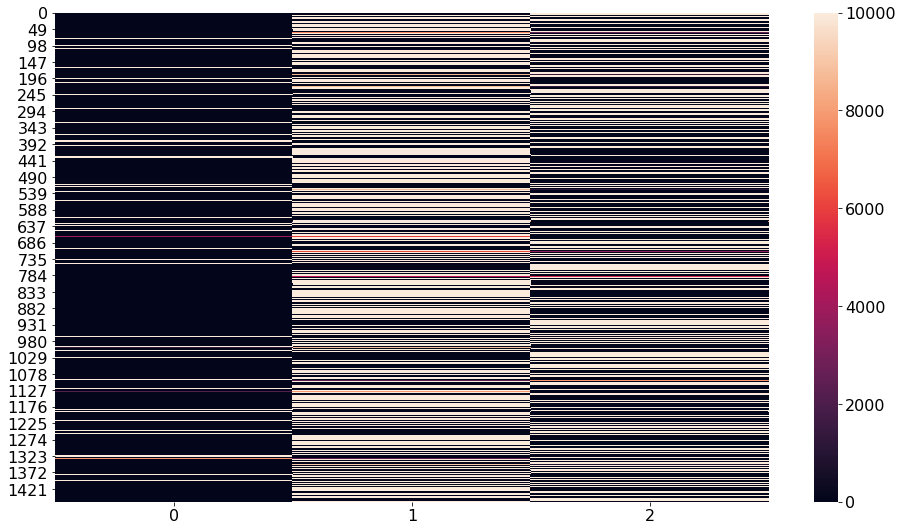

In [82]:
print(cluster_counts.shape)
plt.figure(figsize=(16,9))
sns.heatmap(cluster_counts)
plt.show()

In [83]:
modes = np.zeros(len(df), dtype = np.float64)
for i in range(0,len(df)):
    modes[i] = stats.mode(output[:,i])[0][0]

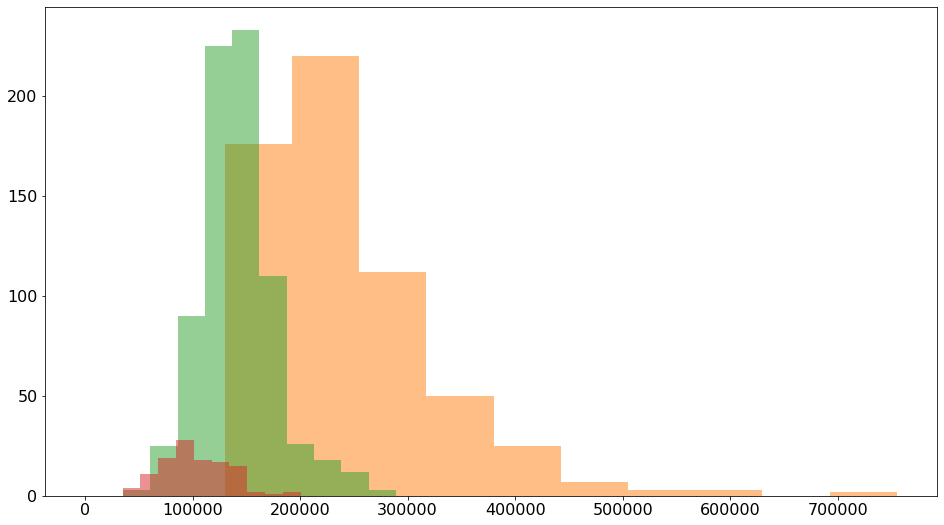

In [84]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for i in range(0,4):
    ax.hist(df[modes == (3-i) ]['SalePrice'],stacked=True,alpha=0.5) #(3-i) for better display in histogram

In [109]:
yX0 = yX[modes == 0]
yX1 = yX[modes == 1]
yX2 = yX[modes == 2]
yX3 = yX[modes == 3]

r_min = 1/3
alpha = 0.05

labels_0 = []
for i in range(0,len(df_model.columns[:-1])):
    r, p = stats.pearsonr(yX0[:,i],yX0[:,0])
    if (np.sqrt(r**2) > r_min) & (p < alpha):
        labels_0.append(i)
yX0 = yX0[:,labels_0]

labels_1 = []
for i in range(0,len(df_model.columns[:-1])):
    r, p = stats.pearsonr(yX1[:,i],yX1[:,0])
    if (np.sqrt(r**2) > r_min) & (p < alpha):
        labels_1.append(i)
yX1 = yX1[:,labels_1]

labels_2 = []
for i in range(0,len(df_model.columns[:-1])):
    r, p = stats.pearsonr(yX2[:,i],yX2[:,0])
    if (np.sqrt(r**2) > r_min) & (p < alpha):
        labels_2.append(i)
yX2 = yX2[:,labels_2]

"""
labels_3 = []
for i in range(0,len(df_model.columns[:-1])):
    r, p = stats.pearsonr(yX3[:,i],yX3[:,0])
    if (np.sqrt(r**2) > r_min) & (p < alpha):
        labels_3.append(i)
yX3 = yX3[:,labels_3]
"""

'\nlabels_3 = []\nfor i in range(0,len(df_model.columns[:-1])):\n    r, p = stats.pearsonr(yX3[:,i],yX3[:,0])\n    if (np.sqrt(r**2) > r_min) & (p < alpha):\n        labels_3.append(i)\nyX3 = yX3[:,labels_3]\n'

In [89]:
!rm 'neighbor_score.npy'
!rm 'neighbor_error.npy'

Time Elapsed: 194.196s
11


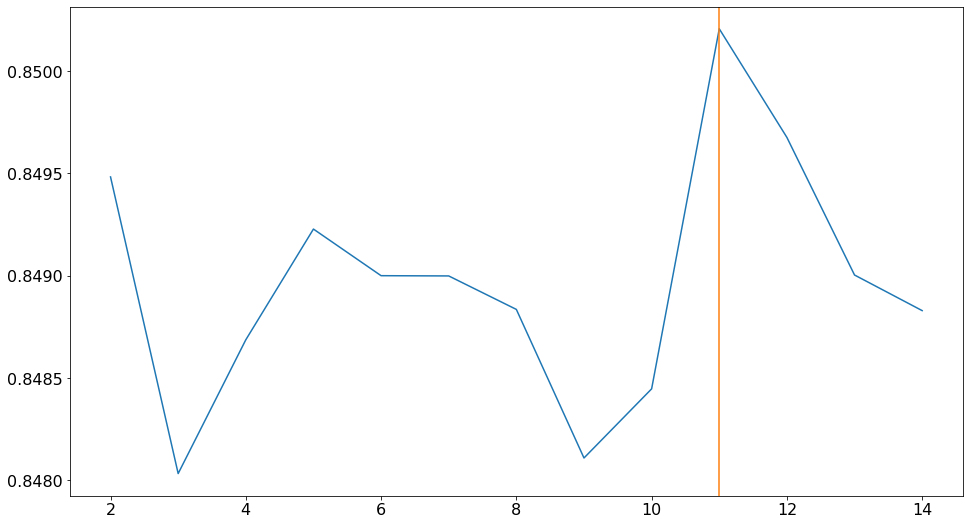

12


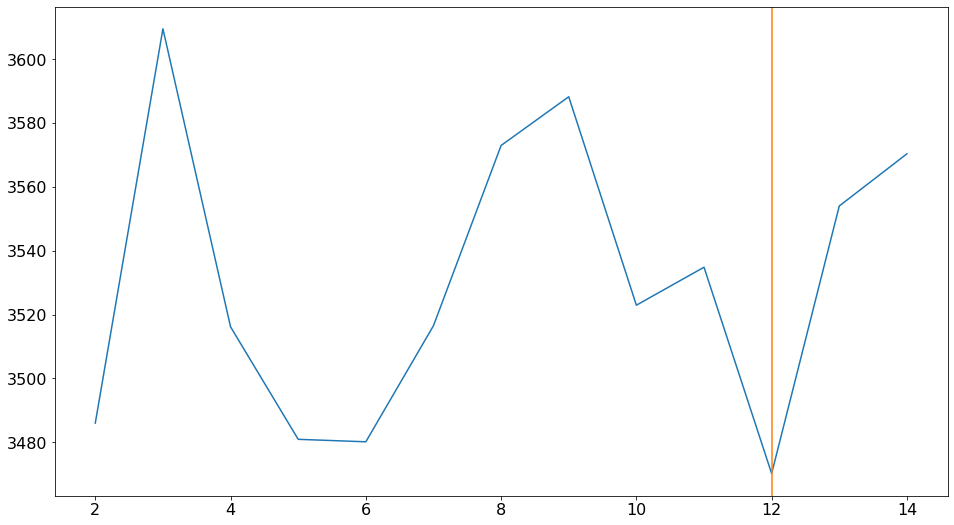

In [90]:
testlen = 5000
neighbors = 15
filename_score = 'neighbor_score.npy'
filename_error = 'neighbor_error.npy'

min_error = 1e9
j_minerror = -1
max_score = -1
j_maxscore = -1
neighbor_error = np.zeros(neighbors, dtype=np.float64)
neighbor_score = np.zeros(neighbors, dtype=np.float64)

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)

output = [scores,error]
job_list = divide_work(template,0)

start_time = time()

try:
    with open(filename_score,'rb') as f:
        neighbor_score = np.load(f)
    with open(filename_error,'rb') as f:
        neighbor_error = np.load(f)    
except:
    if __name__ == '__main__': 
        for j in range(2,neighbors):
            sys.stdout.write(f'{j}\r')
            assign_work(yX, score_model, KNeighborsRegressor(n_neighbors=j), job_list, output)
            neighbor_score[j] = output[0].mean()
            neighbor_error[j] = output[1].mean()
        with open(filename_score,'wb') as f:
            np.save(f,neighbor_score)
        with open(filename_error,'wb') as f:
            np.save(f,neighbor_error)
for j in range(2,neighbors):
    if neighbor_score[j] > max_score:
        max_score = neighbor_score[j]
        j_maxscore = j
    if neighbor_error[j] < min_error:
        min_error = neighbor_error[j]
        j_minerror = j
    else:
        continue

print(f'Time Elapsed: {time() - start_time:.3f}s')
print(j_maxscore)
plt.figure(figsize=(16,9))
plt.plot(np.arange(2,neighbors),neighbor_score[2:])
plt.axvline(j_maxscore,c="C1")
plt.show()
print(j_minerror)
plt.figure(figsize=(16,9))
plt.plot(np.arange(2,neighbors),neighbor_error[2:])
plt.axvline(j_minerror,c="C1")
plt.show()

In [120]:
#!rm 'cluster0_lr.pkl'

Go!
Time Elapsed: 56.717s
['LotArea', 'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtHalfBath', 'FullBath', 'MSZoning_ranks', 'Exterior1st_ranks']


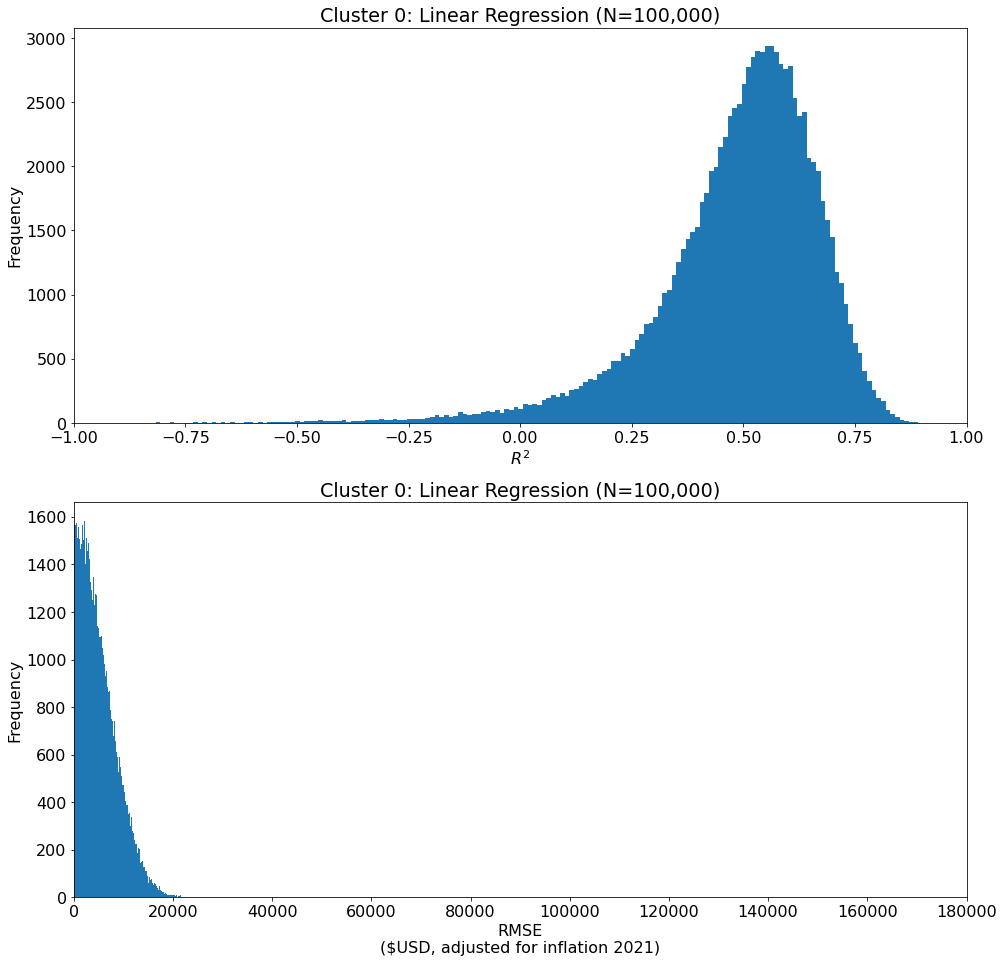

Scores 
  nobs:    	100000
  minmax:  	(-1.711981046893217, 0.8917942609745791)
  mean:    	0.48645923494096227
  variance:	0.03551993838533447
  skewness:	-1.6674573688252163
  kurtosis:	5.7671211021347535
 Error  
  nobs:    	100000
  minmax:  	(0.015379853245273504, 31247.33326113695)
  mean:    	5053.240013638797
  variance:	14155038.920156287
  skewness:	0.940210270144917
  kurtosis:	0.6779261617701868


In [121]:
filename = 'cluster0_lr.pkl'
testlen = 100000
try:
    with open(filename,'rb') as f:
        output = pickle.load(f)
except:
    print('Go!')
    start_time = time()
    template = np.zeros(testlen,dtype=np.float64)
    scores_shm = SharedMemory(create=True, size=template.nbytes)
    scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)
    error_shm = SharedMemory(create=True, size=template.nbytes)
    error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)
    model = LinearRegression()
    #model = RandomForestRegressor()
    #model = KNeighborsRegressor(n_neighbors=j_minerror)
    output = [scores,error]
    job_list = divide_work(template, 0)
    start_time = time()
    if __name__ == '__main__':  
        assign_work(yX0, score_model, model, job_list, output)
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    with open(filename,'wb') as f:
        pickle.dump(output, f)

print([labels[i] for i in labels_0[1:]])
draw_plots('Cluster 0: Linear Regression',output,250)

In [124]:
#!rm 'cluster1_lr.pkl'

rm: cluster1_lr.pkl: No such file or directory


Go!
Time Elapsed: 62.221s
['BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'WoodDeckSF', 'PoolArea', 'MSZoning_ranks', 'ExterCond_ranks']


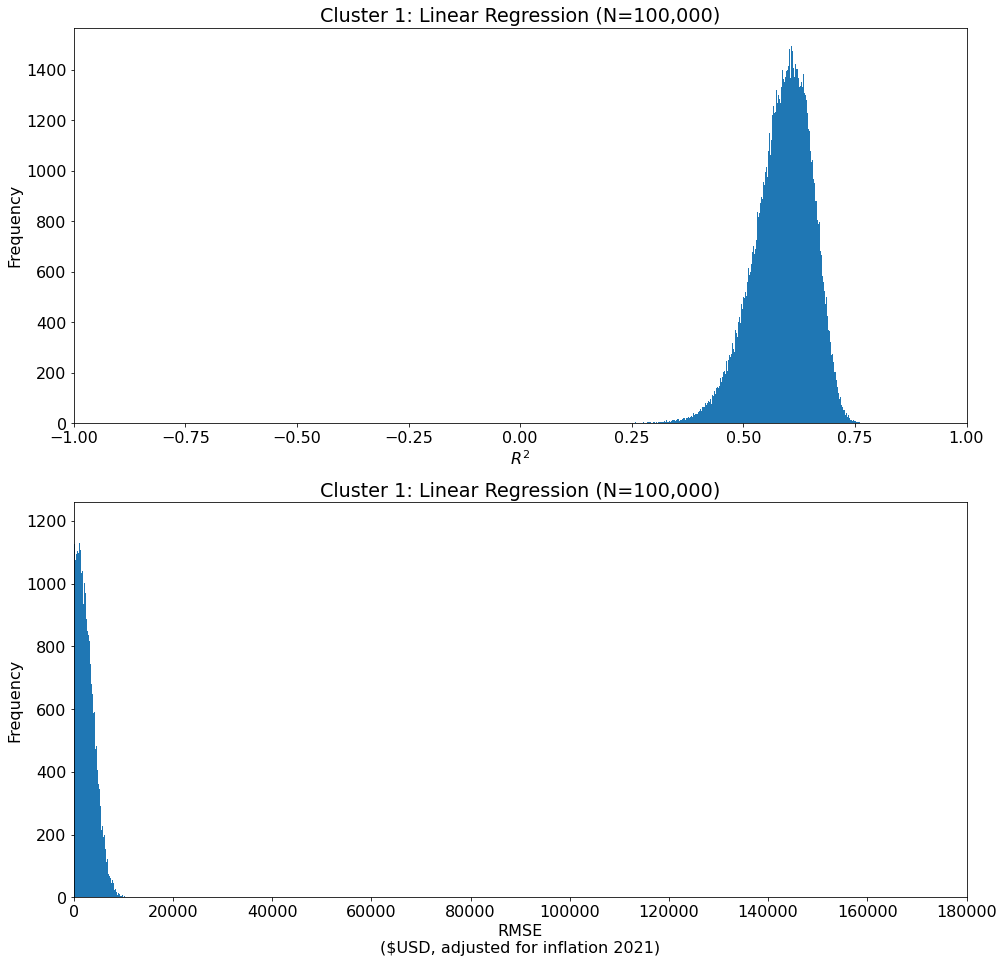

Scores 
  nobs:    	100000
  minmax:  	(0.228667701655616, 0.7875636857215353)
  mean:    	0.5880763426183644
  variance:	0.004112102773506776
  skewness:	-0.5807633259293482
  kurtosis:	0.44574165665720944
 Error  
  nobs:    	100000
  minmax:  	(0.04579441940928372, 11974.271136543046)
  mean:    	2536.7379371166153
  variance:	3332175.5544622797
  skewness:	0.8200356328841331
  kurtosis:	0.3237995938083693


In [125]:
filename = 'cluster1_lr.pkl'
testlen = 100000
try:
    with open(filename,'rb') as f:
        output = pickle.load(f)
except:
    print('Go!')
    start_time = time()
    template = np.zeros(testlen,dtype=np.float64)
    scores_shm = SharedMemory(create=True, size=template.nbytes)
    scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)
    error_shm = SharedMemory(create=True, size=template.nbytes)
    error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)
    model = LinearRegression()
    #model = RandomForestRegressor()
    #model = KNeighborsRegressor(n_neighbors=j_minerror)
    output = [scores,error]
    job_list = divide_work(template, 0)
    start_time = time()
    if __name__ == '__main__':  
        assign_work(yX1, score_model, model, job_list, output)
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    with open(filename,'wb') as f:
        pickle.dump(output, f)

print([labels[i] for i in labels_1[1:]])
draw_plots('Cluster 1: Linear Regression',output,250)

In [127]:
#!rm 'cluster2_lr.pkl'

rm: cluster2_lr.pkl: No such file or directory


Go!
Time Elapsed: 66.774s
['MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'PoolArea', 'MSZoning_ranks', 'Alley_ranks', 'LandSlope_ranks', 'Condition2_ranks', 'MasVnrType_ranks', 'ExterCond_ranks']


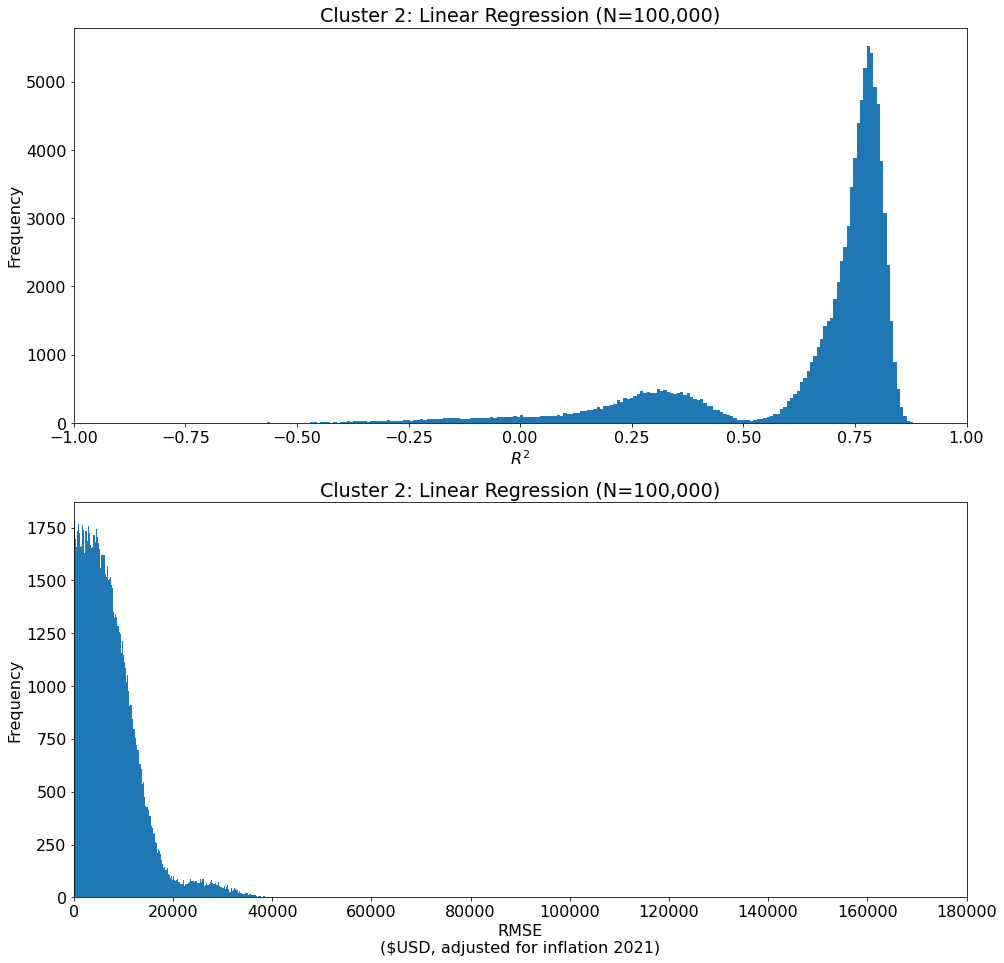

Scores 
  nobs:    	100000
  minmax:  	(-0.9862371282801129, 0.8811821948027362)
  mean:    	0.6457137184472643
  variance:	0.057319423610134194
  skewness:	-1.9373055803614387
  kurtosis:	3.321533433982184
 Error  
  nobs:    	100000
  minmax:  	(0.20608829941556905, 53779.89230988538)
  mean:    	7543.12882894103
  variance:	36133219.13707676
  skewness:	1.5690607850631226
  kurtosis:	3.507214652711074


In [128]:
filename = 'cluster2_lr.pkl'
testlen = 100000
try:
    with open(filename,'rb') as f:
        output = pickle.load(f)
except:
    print('Go!')
    start_time = time()
    template = np.zeros(testlen,dtype=np.float64)
    scores_shm = SharedMemory(create=True, size=template.nbytes)
    scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)
    error_shm = SharedMemory(create=True, size=template.nbytes)
    error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)
    model = LinearRegression()
    #model = RandomForestRegressor()
    #model = KNeighborsRegressor(n_neighbors=j_minerror)
    output = [scores,error]
    job_list = divide_work(template, 0)
    start_time = time()
    if __name__ == '__main__':  
        assign_work(yX2, score_model, model, job_list, output)
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    with open(filename,'wb') as f:
        pickle.dump(output, f)

print([labels[i] for i in labels_2[1:]])
draw_plots('Cluster 2: Linear Regression',output,250)

filename = 'cluster3_lr.pkl'
testlen = 100000
try:
    with open(filename,'rb') as f:
        output = pickle.load(f)
except:
    print('Go!')
    start_time = time()
    template = np.zeros(testlen,dtype=np.float64)
    scores_shm = SharedMemory(create=True, size=template.nbytes)
    scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)
    error_shm = SharedMemory(create=True, size=template.nbytes)
    error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)
    model = LinearRegression()
    #model = SVR()
    #model = GradientBoostingRegressor()
    #model = Ridge(alpha = 1.0)
    #model = RandomForestRegressor()
    #model = KNeighborsRegressor(n_neighbors=j_minerror)
    output = [scores,error]
    job_list = divide_work(template, 0)
    start_time = time()
    if __name__ == '__main__':  
        assign_work(yX3, score_model, model, job_list, output)
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    with open(filename,'wb') as f:
        pickle.dump(output, f)
print([labels[i] for i in labels_3[1:]])
draw_plots('Cluster 3: Linear Regression',output,250)

In [129]:
df_test =  pd.read_csv('./input/test.csv')
df_test.shape

(1459, 80)

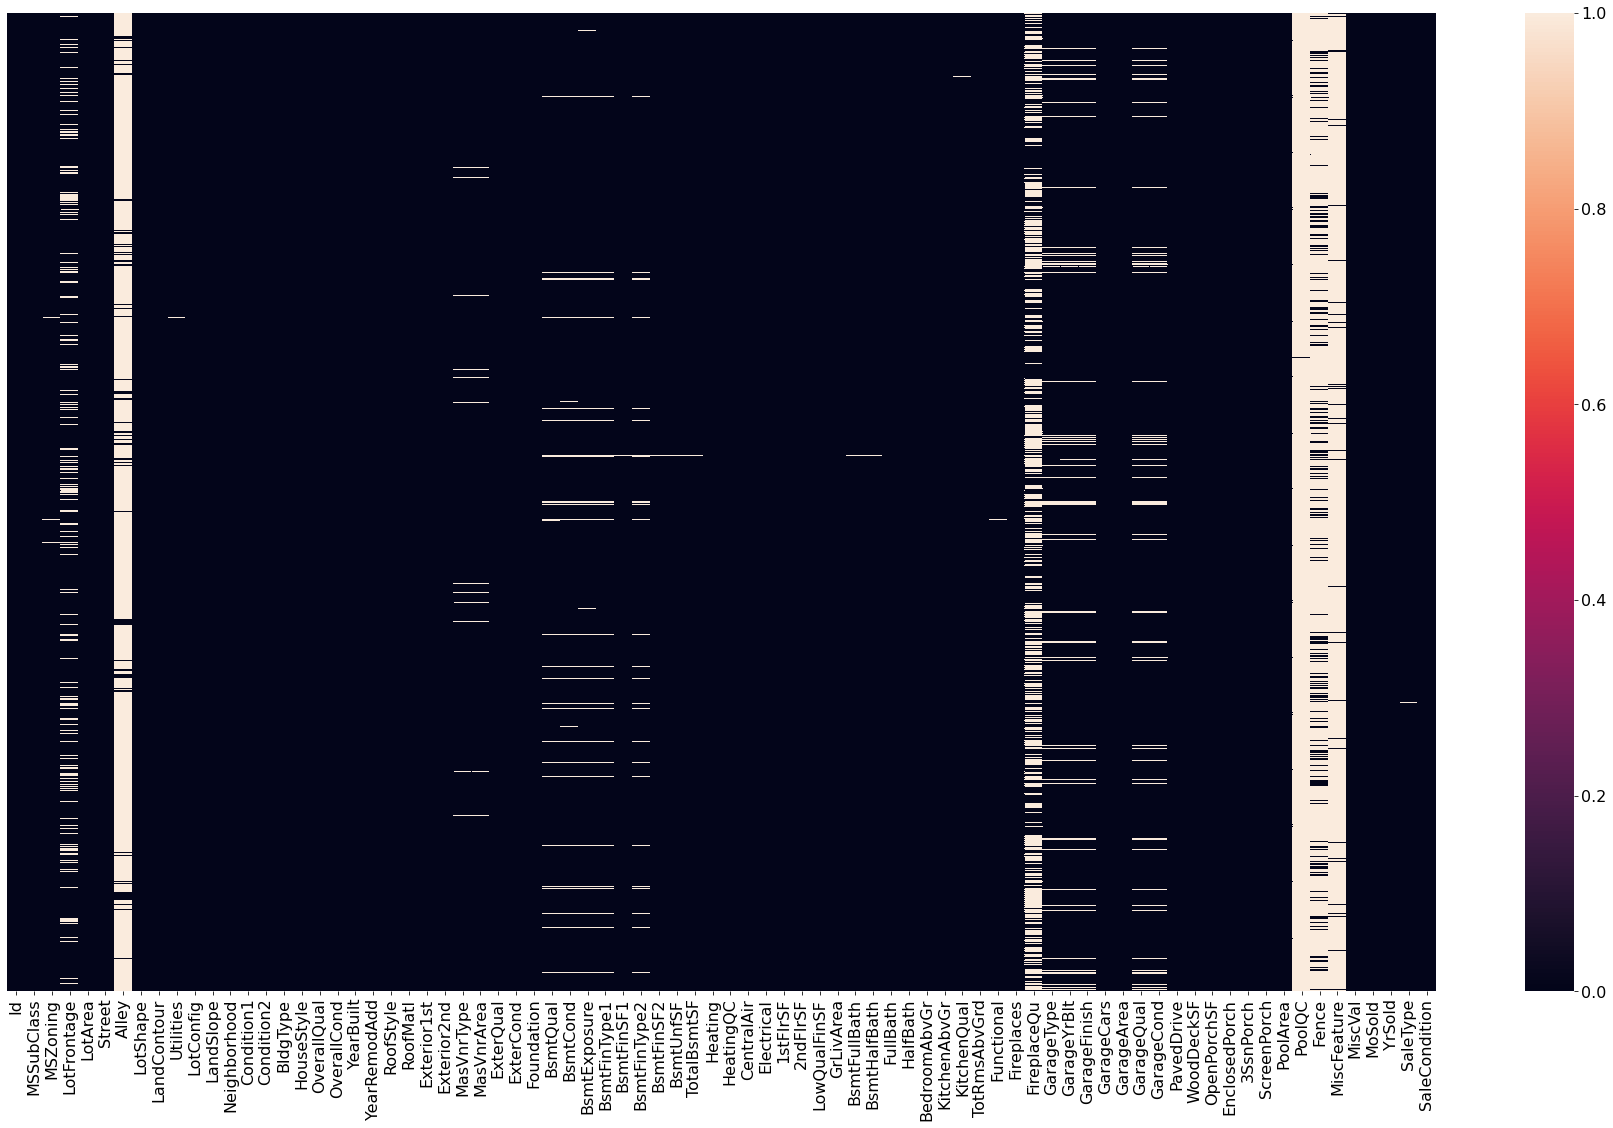

In [130]:
plt.figure(figsize=(32,18))
sns.heatmap(df_test.isnull())
plt.tick_params(left=False,
                labelleft=False)
plt.show()

In [131]:
# This isn't very elegant. Try to make this less brute forcey, more modular.
# It's a pretty regular task and would benefit from attention.

mean_frontage_ratio = np.mean(df['LotFrontage']/df['LotArea'])
df_test['LotFrontage'].replace(np.nan,mean_frontage_ratio*df['LotArea'],inplace=True)
df_test['Alley'].replace(np.nan,'None',inplace=True)
df_test['MasVnrArea'].replace(np.nan,0,inplace=True)
df_test['MasVnrType'].replace(np.nan,'None',inplace=True)
df_test['BsmtQual'].replace(np.nan,'None',inplace=True)
df_test['BsmtCond'].replace(np.nan,'None',inplace=True)
df_test['BsmtExposure'].replace(np.nan,'None',inplace=True)
df_test['BsmtFinType1'].replace(np.nan,'None',inplace=True)
df_test['BsmtFinType2'].replace(np.nan,'None',inplace=True)
df_test['Electrical'].replace(np.nan,'SBrkr',inplace=True)
df_test['FireplaceQu'].replace(np.nan,'None',inplace=True)
df_test['GarageType'].replace(np.nan,'None',inplace=True)
df_test['GarageYrBlt'].replace(np.nan,df['GarageYrBlt'].mean(),inplace=True)
df_test['GarageFinish'].replace(np.nan,'None',inplace=True)
df_test['GarageQual'].replace(np.nan,'None',inplace=True)
df_test['GarageCond'].replace(np.nan,'None',inplace=True)
df_test['PoolQC'].replace(np.nan,'None',inplace=True)
df_test['Fence'].replace(np.nan,'None',inplace=True)
df_test['MiscFeature'].replace(np.nan,'None',inplace=True)
df_test['Exterior2nd'].replace(np.nan,'VinylSd',inplace=True)
df_test['Exterior1st'].replace(np.nan,'VinylSd',inplace=True)
df_test['Utilities'].replace(np.nan,'AllPub',inplace=True)
df_test['LandContour'].replace(np.nan,'Lvl',inplace=True)
df_test['MSZoning'].replace(np.nan,'RL',inplace=True)
df_test['BsmtFinSF1'].replace(np.nan,df['BsmtFinSF1'].mean(),inplace=True)
df_test['BsmtFinSF2'].replace(np.nan,df['BsmtFinSF2'].mean(),inplace=True)
df_test['TotalBsmtSF'].replace(np.nan,df['TotalBsmtSF'].mean(),inplace=True)
df_test['BsmtUnfSF'].replace(np.nan,df['TotalBsmtSF'].mean(),inplace=True)
df_test['BsmtFullBath'].replace(np.nan,stats.mode(df_test.BsmtFullBath)[0][0],inplace=True)
df_test['BsmtHalfBath'].replace(np.nan,stats.mode(df_test.BsmtHalfBath)[0][0],inplace=True)
df_test['KitchenQual'].replace(np.nan,stats.mode(df_test.KitchenQual)[0][0],inplace=True)
df_test['Functional'].replace(np.nan,stats.mode(df_test.Functional)[0][0],inplace=True)
df_test['GarageCars'].replace(np.nan,stats.mode(df_test.GarageCars)[0][0],inplace=True)
df_test['GarageArea'].replace(np.nan,stats.mode(df_test.GarageArea)[0][0],inplace=True)
df_test['SaleType'].replace(np.nan,stats.mode(df_test.SaleType)[0][0],inplace=True)

for column in df_test.columns:
    if df_test[column].isnull().any():
        print(column)

In [132]:
def get_ranks2(FEATURE, DF1, DF2, TARGET):
    ftr_mean = np.zeros(len(DF1[FEATURE].unique()))
    vecs = get_vecs(FEATURE, DF1, TARGET)
    for i in range(len(ftr_mean)):
        ftr_mean[i] = np.mean(vecs[0][i])
    ftr_rank = np.zeros(len(DF2),dtype=np.float64)
    target_mean = np.mean(DF1[TARGET])
    target_std = np.std(DF1[TARGET])
    for i in range(len(DF2)):
        for j in range(len(vecs[1])):
            if DF2[FEATURE][i] == vecs[1][j]:
                if  ftr_mean[j] <= (target_mean - target_std):
                    ftr_rank[i] = 1
                if (ftr_mean[j] > (target_mean - target_std)) & (ftr_mean[j] <= target_mean):
                    ftr_rank[i] = 2
                if (ftr_mean[j] <= (target_mean + target_std)) & (ftr_mean[j] > target_mean):
                    ftr_rank[i] = 3
                if (ftr_mean[j] > (target_mean + target_std)):
                    ftr_rank[i] = 4
    return ftr_rank

In [133]:
# Begin by including all features in our model
filename = 'predict.pkl'

try:
    with open(filename,'rb') as f:
        df_predict = pickle.load(f)
except:    
    print('Building new model')
    df_predict = pd.DataFrame()
    for i in range(len(categoric)):
        try:
            tmp_str = categoric[i] + '_ranks'
            df_predict.loc[:,tmp_str] = get_ranks2(categoric[i],df,df_test,'adjprice')
        except:
            continue
    df_cats = df_test.loc[:,numeric]
    df_predict = df_cats.merge(df_predict, how='inner', left_index=True,right_index=True)
    df_predict = df_predict.drop('SalePrice',axis=1)
    df_predict = df_predict.drop('adjprice',axis=1)
    with open(filename,'wb') as f:
        pickle.dump(df_predict,f)

df_predict[0:5]

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageType_ranks,GarageFinish_ranks,GarageQual_ranks,GarageCond_ranks,PavedDrive_ranks,PoolQC_ranks,Fence_ranks,MiscFeature_ranks,SaleType_ranks,SaleCondition_ranks
0,1461,80.0,11622,1961,1961,0.0,468.0,144.0,270.0,882.0,...,3.0,2.0,3.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0
1,1462,81.0,14267,1958,1958,108.0,923.0,0.0,406.0,1329.0,...,3.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0
2,1463,74.0,13830,1997,1998,0.0,791.0,0.0,137.0,928.0,...,3.0,3.0,3.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0
3,1464,78.0,9978,1998,1998,20.0,602.0,0.0,324.0,926.0,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0
4,1465,43.0,5005,1992,1992,0.0,263.0,0.0,1017.0,1280.0,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0


In [173]:
list(df_model.columns)

['adjprice',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'ScreenPorch',
 'MSSubClass_ranks',
 'MSZoning_ranks',
 'Alley_ranks',
 'LotShape_ranks',
 'LandContour_ranks',
 'LotConfig_ranks',
 'Neighborhood_ranks',
 'Condition1_ranks',
 'Condition2_ranks',
 'BldgType_ranks',
 'HouseStyle_ranks',
 'OverallQual_ranks',
 'OverallCond_ranks',
 'RoofStyle_ranks',
 'RoofMatl_ranks',
 'Exterior1st_ranks',
 'Exterior2nd_ranks',
 'MasVnrType_ranks',
 'ExterQual_ranks',
 'ExterCond_ranks',
 'Foundation_ranks',
 'BsmtQual_ranks',
 'BsmtCond_ranks',
 'BsmtExposure_ranks',
 'BsmtFinType1_ranks',
 'BsmtFinType2_ranks',
 'Heating_ranks',
 'HeatingQC_ranks',
 'CentralAir_ranks',
 'Electrical_ranks',
 'KitchenQual_ranks',
 'F

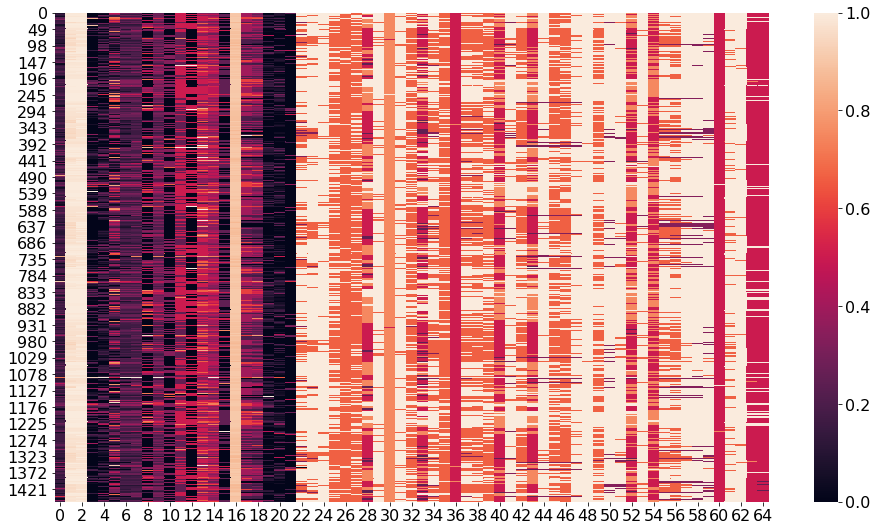

In [176]:
#NOTE: df_model.columns[0] = 'adjprice' -----------------v
X_pred = np.array(df_predict.loc[:,list(df_model.columns[1:])], dtype = np.float64) 

labels_pred = list(df_predict.columns)

plt.figure(figsize=(16,9))
sns.heatmap(X_pred[:,1:])
plt.show()

In [177]:
yX.shape

(1460, 67)

In [178]:
X_pred.shape

(1459, 66)

In [ ]:
def get_ranks2(FEATURE, DF1, DF2, TARGET):
    ftr_mean = np.zeros(len(DF1[FEATURE].unique()))
    vecs = get_vecs(FEATURE, DF1, TARGET)
    for i in range(len(ftr_mean)):
        ftr_mean[i] = np.mean(vecs[0][i])
    ftr_rank = np.zeros(len(DF1),dtype=np.float64)
    target_mean = np.mean(DF1[TARGET])
    target_std = np.std(DF1[TARGET])
    
    
    for i in range(len(DF2)):
        for j in range(len(vecs[1])):
            if DF2[FEATURE][i] == vecs[1][j]:
                if  ftr_mean[j] <= (target_mean - target_std):
                    ftr_rank[i] = 1
                if (ftr_mean[j] > (target_mean - target_std)) & (ftr_mean[j] <= target_mean):
                    ftr_rank[i] = 2
                if (ftr_mean[j] <= (target_mean + target_std)) & (ftr_mean[j] > target_mean):
                    ftr_rank[i] = 3
                if (ftr_mean[j] > (target_mean + target_std)):
                    ftr_rank[i] = 4
    return ftr_rank

In [207]:
def assign_clusters2(INPUT, OUTPUT, MODEL_TYPE, OFFSET, DURATION):
    data_fit = INPUT[0]
    X_fit = data_fit[:,1:]
    y_fit = data_fit[:,0]
    data_pred = INPUT[1]
    X_pred = data_pred[:,:]

    centers = np.zeros((clusters,X_fit.shape[1]),dtype=np.float64)
    response = np.zeros((len(centers),2),dtype=np.float64)
    response_sorted = np.zeros((len(centers),2),dtype=np.float64)
    labels = np.zeros((len(X_pred),2),dtype=np.float64) # format: (original label, ordered label)
    
    for i in range(0, DURATION):
        seed = np.random.seed()
        rng = np.random.default_rng(seed)
        mask = rng.choice([True, False], size=len(X_fit), p=[0.8, 0.2])
        X_masked = X_fit[mask]
        y_masked = y_fit[mask]
        cls = MODEL_TYPE
        cls.fit(X_masked)
        centers = cls.cluster_centers_
        reg = LinearRegression()
        reg.fit(X_masked,y_masked)
        # Get response from centers and calculate y at those centers
        for j in range(0,len(centers)):
            response[j,0] = cls.predict(centers[j].reshape(1,-1))[0]
            response[j,1] = reg.predict(centers[j].reshape(1,-1))[0]
        # Sort centers in order of response
        for j in range(0,len(centers)):
            response_sorted[j] = response[np.argsort(response[:,1])[j]]
        # Get labels
        labels[:,0] = cls.predict(X_pred)
        # Now labels are reassigned in increasing response order
        # For each sample...
        for j in range(0,len(labels)):
            # loop through the cluster labels...
            for k in range(0,len(response_sorted)):
                # if the sample label matches the the *sorted* center label,
                # fill in the ordered label with the index
                if labels[j,0] == response_sorted[k,0]:
                    labels[j,1] = k
                # Since the centers are sorted, the new labels will be as well
            OUTPUT[i + OFFSET][j] = labels[j,1]

In [209]:
!rm 'testcluster_labels.pkl'

In [210]:
filename = 'testcluster_labels.pkl'

try:
    with open(filename,'rb') as f:
        output = pickle.load(f)
except:
    testlen = 10000
    template = np.zeros((testlen,len(X_pred)), 
                        dtype=np.float64)
    clusters_shm = SharedMemory(create=True,
                                size=template.nbytes)
    cluster_labels = np.ndarray((testlen,len(X_pred)),
                                dtype=template.dtype, 
                                buffer=clusters_shm.buf)
    model = KMeans(n_clusters = 3)
    output = cluster_labels
    job_list = divide_work(template, 0)
    start_time = time()
    INPUT = [yX,X_pred]
    
    if __name__ == '__main__':  
        assign_work(INPUT, assign_clusters2, model, job_list, output)
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    
    with open(filename,'wb') as f:
        pickle.dump(output, f)
print(output.shape)

Time Elapsed: 355.635s
(10000, 1459)


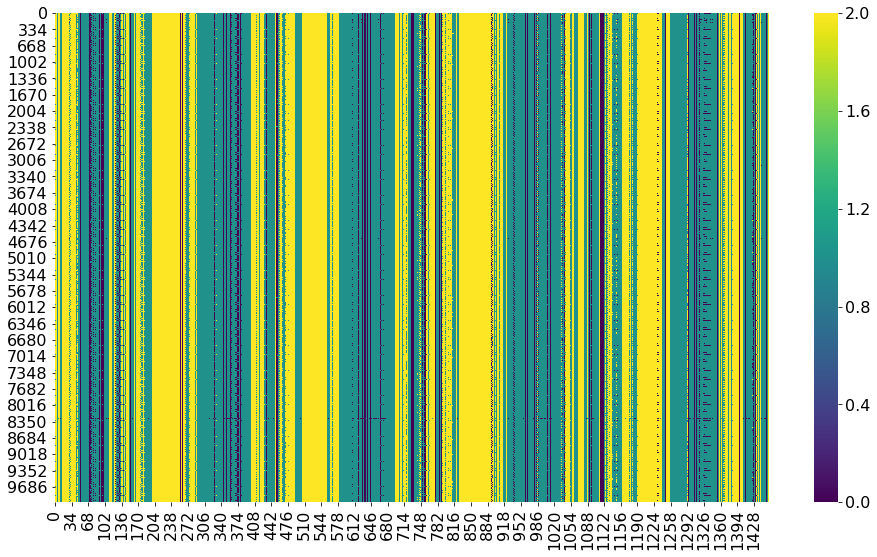

In [257]:
plt.figure(figsize=(16,9))
sns.heatmap(output,cmap='viridis')
plt.show()

In [215]:
modes_test = np.zeros(len(df_test), dtype = np.float64)
for i in range(0,len(df_test)):
    modes_test[i] = stats.mode(output[:,i])[0][0]

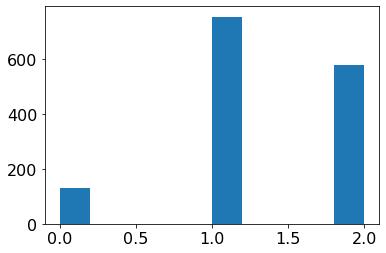

In [216]:
plt.hist(modes_test)
plt.show()

In [217]:
df_predict.loc[:,'cluster'] = modes_test

In [242]:
X0_pred = df_predict.iloc[:,labels_0][df_predict['cluster'] == 0]
X0_pred.shape
X1_pred = df_predict.iloc[:,labels_1[1:]][df_predict['cluster'] == 1]
X1_pred.shape

cls1 = RandomForestRegressor()
cls1.fit(yX1[:,1:],yX1[:,0])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

(array([ 18.,  21.,   3., 252., 181.,  27.,  94.,   7.,  46., 104.]),
 array([ 68493.58882675,  87675.48399054, 106857.37915433, 126039.27431812,
        145221.16948191, 164403.06464569, 183584.95980948, 202766.85497327,
        221948.75013706, 241130.64530084, 260312.54046463]),
 <a list of 10 Patch objects>)

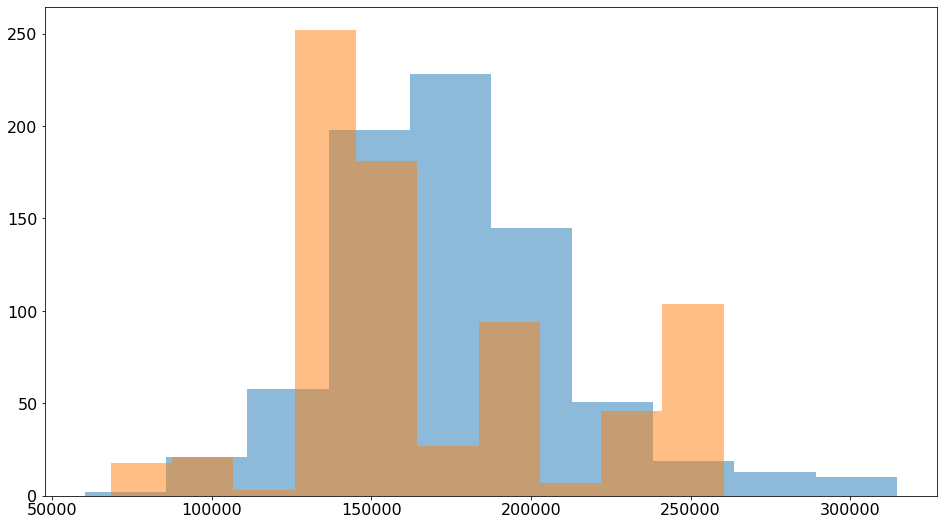

In [243]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.hist(np.exp(cls1.predict(yX1[:,1:])),stacked=True,alpha=0.5) #(3-i) for better display in histogram
ax.hist(np.exp(cls1.predict(X1_pred)),stacked=True,alpha=0.5)